<h1>Análise e Correlações do Preço do Frete na Importação</h1>
<hr>

## Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Bibliotecas

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

import re

## Coleta, Processamento e Tratamento dos dados
---


### Dados das Importações Brasileiras
Link: [Ministério da Economia](https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/IMP_COMPLETA.zip)

In [3]:
# Coletando os dados
df_importacao = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/IMP_COMPLETA.csv",sep=';')
#df_importacao = pd.read_csv('../datasets/IMP_COMPLETA.csv',sep=';')


In [4]:
# Informações de linhas e colunas do dataset df_urf
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36389808 entries, 0 to 36389807
Data columns (total 13 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   CO_ANO      int64 
 1   CO_MES      int64 
 2   CO_NCM      int64 
 3   CO_UNID     int64 
 4   CO_PAIS     int64 
 5   SG_UF_NCM   object
 6   CO_VIA      int64 
 7   CO_URF      int64 
 8   QT_ESTAT    int64 
 9   KG_LIQUIDO  int64 
 10  VL_FOB      int64 
 11  VL_FRETE    int64 
 12  VL_SEGURO   int64 
dtypes: int64(12), object(1)
memory usage: 3.5+ GB


In [5]:
# Filtrando dados dos últimos 10 anos (2012 - 2022)
df_importacao = df_importacao[df_importacao.CO_ANO >= 2012]

# Filtrando as 20 NCM mais importadas em valor FOB
df = df_importacao.groupby(['CO_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
fob_total = df.VL_FOB.sum()
df = df.iloc[:20,:][['VL_FOB']]
df.reset_index(inplace=True)
df_importacao = df_importacao[df_importacao.CO_NCM.isin(df.CO_NCM)]

In [6]:
# Percentual que essas NCM representam no valor FOB
maiores_ncm = df.iloc[:20,:]
fob_maiores_ncm = maiores_ncm.VL_FOB.sum()
perc_ncm = fob_maiores_ncm/fob_total
print(f'O percentual que essas NCM representam no valor FOB é de {perc_ncm:.1%}')

O percentual que essas NCM representam no valor FOB é de 25.5%


In [7]:
# Informações de linhas e colunas do dataset df_importacao
df_importacao.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117814 entries, 17700319 to 36389722
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      117814 non-null  int64 
 1   CO_MES      117814 non-null  int64 
 2   CO_NCM      117814 non-null  int64 
 3   CO_UNID     117814 non-null  int64 
 4   CO_PAIS     117814 non-null  int64 
 5   SG_UF_NCM   117814 non-null  object
 6   CO_VIA      117814 non-null  int64 
 7   CO_URF      117814 non-null  int64 
 8   QT_ESTAT    117814 non-null  int64 
 9   KG_LIQUIDO  117814 non-null  int64 
 10  VL_FOB      117814 non-null  int64 
 11  VL_FRETE    117814 non-null  int64 
 12  VL_SEGURO   117814 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 12.6+ MB


In [8]:
# Visualização do cabeçalho do dataset df_importacao
df_importacao.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700319,2012,6,85299020,10,351,SP,4,817700,35,35,3252,538,3
17700372,2012,2,31042090,10,149,GO,1,817800,6900000,6900000,3656925,207000,6769
17700388,2012,8,85299020,10,23,SP,1,817800,0,0,167,0,0
17700566,2012,12,84119100,10,149,RJ,4,817700,511,511,1280002,5618,0
17700804,2012,11,84119100,10,249,MG,4,817700,200,200,568191,2602,0


### Tabelas auxiliares
---
Link: [Tabela Códigos](https://balanca.economia.gov.br/balanca/bd/tabelas/TABELAS_AUXILIARES.xlsx)

Indice Excel usado
* 1 (NO_NCM_POR): Descrição NCM
* 10 (CO_PAIS): País de origem do produto
* 14 (CO_VIA): Meio de transporte da mercadoria
* 15 (CO_URF): Local de chegada no Brasil da mercadoria


In [9]:
# Coletando os dados

url = "https://github.com/Migliorin/Comex_Data_Analysis/blob/main/datasets/TABELAS_AUXILIARES.xlsx?raw=true"
xl_file = pd.ExcelFile(url)

#xl_file = pd.ExcelFile('../datasets/TABELAS_AUXILIARES.xlsx')
df_ncm = xl_file.parse('1')
df_pais = xl_file.parse('10')
df_via = xl_file.parse('14')
df_urf = xl_file.parse('15')

In [365]:
# Informações de linhas e colunas do dataset df_ncm
df_ncm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13164 entries, 0 to 13163
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_NCM         13164 non-null  int64 
 1   NO_NCM_POR     13164 non-null  object
 2   CO_SH6         13164 non-null  int64 
 3   NO_SH6_POR     13164 non-null  object
 4   NO_SH6_ESP     13164 non-null  object
 5   NO_SH6_ING     13164 non-null  object
 6   CO_SH4         13164 non-null  int64 
 7   NO_SH4_POR     13164 non-null  object
 8   NO_SH4_ESP     13164 non-null  object
 9   NO_SH4_ING     13164 non-null  object
 10  CO_SH2         13164 non-null  int64 
 11  NO_SH2_POR     13164 non-null  object
 12  NO_SH2_ESP     13164 non-null  object
 13  NO_SH2_ING     13164 non-null  object
 14  CO_NCM_SECROM  13164 non-null  object
 15  NO_SEC_POR     13164 non-null  object
 16  NO_SEC_ESP     13164 non-null  object
 17  NO_SEC_ING     13164 non-null  object
dtypes: int64(4), object(14)
me

In [366]:
# Informações de linhas e colunas do dataset df_pais
df_pais.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CO_PAIS        281 non-null    int64 
 1   CO_PAIS_ISON3  281 non-null    int64 
 2   CO_PAIS_ISOA3  281 non-null    object
 3   NO_PAIS        281 non-null    object
 4   NO_PAIS_ING    281 non-null    object
 5   NO_PAIS_ESP    281 non-null    object
dtypes: int64(2), object(4)
memory usage: 13.3+ KB


In [367]:
# Informações de linhas e colunas do dataset df_via
df_via.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_VIA  17 non-null     int64 
 1   NO_VIA  17 non-null     object
dtypes: int64(1), object(1)
memory usage: 400.0+ bytes


In [368]:
# Informações de linhas e colunas do dataset df_urf
df_urf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CO_URF  276 non-null    int64 
 1   NO_URF  276 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.4+ KB


### Substituição código
---
Para melhor análise e entedimento, será usado a tabela de códigos para substituir os códigos dentro da base bruta. Como as colunas de alguns códigos serão traduzidas, então serão retirados as seguintes colunas:

* CO_NCM
* CO_PAIS
* CO_VIA
* CO_URF

In [10]:
# Unindo os datasets auxiliares com o df_importacao 
df_importacao = df_importacao.merge(df_ncm[['CO_NCM','NO_NCM_POR']],on='CO_NCM')
df_importacao = df_importacao.merge(df_pais[['CO_PAIS','NO_PAIS']],on='CO_PAIS')
df_importacao = df_importacao.merge(df_urf[['CO_URF','NO_URF']],on='CO_URF')
df_importacao = df_importacao.merge(df_via[['CO_VIA','NO_VIA']],on='CO_VIA')

# Criando a coluna NCM, concatenando o código e o nome da NCM 
df_importacao["NCM"] = df_importacao["CO_NCM"].map(str) + " - " + df_importacao["NO_NCM_POR"]

# Apagando as colunas dos códigos que foram utilizadas na união e o nome da NCM
df_importacao.drop(['CO_NCM','CO_PAIS','CO_URF','CO_VIA', 'NO_NCM_POR'],axis=1,inplace=True)

# Reordenando as colunas para melhor visualização
df_importacao = df_importacao[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','VL_FOB','VL_SEGURO','VL_FRETE']]

In [370]:
df_importacao.head()

,CO_ANO,CO_MES,NCM,CO_UNID,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,35,3252,3,538
1,2012,10,85299020 - Outras partes para aparelhos recept...,10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,3,3,201,0,28
2,2012,4,85299020 - Outras partes para aparelhos recept...,10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,136,136,7441,4,2056
3,2012,8,85299020 - Outras partes para aparelhos recept...,10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,85,85,11577,22,784
4,2012,11,85299020 - Outras partes para aparelhos recept...,10,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,220,220,2902,133,15754


### Dolar Série Histórica
---
Link: [Dolar Serie Historica](https://www.cepea.esalq.usp.br/br/serie-de-preco/dolar.aspx)

In [11]:
# Coletando os dados
df_dolar = pd.read_csv("/content/drive/Shareddrives/TCC Daniel dados/export_series_dolar.csv",sep=';')

In [372]:
# Informações de linhas e colunas do dataset df_urf
df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6398 entries, 0 to 6397
Data columns (total 1 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30  6398 non-null   object
dtypes: object(1)
memory usage: 50.1+ KB


In [12]:
# Criando as colunas ano, mes e COTACAO a partir da coluna do dataset df_dolar
df_dolar["ano"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[6:10])
df_dolar["mes"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[3:5])
df_dolar["COTACAO"] = df_dolar["Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30"].apply(lambda x: str(x)[11:])

# Apagando a coluna inicial do dataset df_dolar
df_dolar.drop(['Data da serie,DOLAR COMERCIAL ATUALIZADO AS 16H30'],axis=1,inplace=True)

# Substituindo a vírgula por ponto na string que representa a cotação e tirando as aspas
df_dolar["COTACAO"] = df_dolar["COTACAO"].str.replace(',','.').str.replace('"','')

# Alterando os tipos das colunas ano, mes e COTACAO
df_dolar["ano"] = df_dolar["ano"].astype(int)
df_dolar["mes"] = df_dolar["mes"].astype(int)
df_dolar["COTACAO"] = df_dolar["COTACAO"].astype(float)

# Filtrando dados dos últimos 10 anos (2012 - 2022)
df_dolar = df_dolar[df_dolar.ano >= 2012]

# Agrupando os valores por mês e ano utilizando a média das cotações 
df_dolar = df_dolar.groupby(['ano','mes']).mean()
df_dolar.reset_index(inplace=True)

# Informações de linhas e colunas do dataset df_dolar
df_dolar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ano      123 non-null    int64  
 1   mes      123 non-null    int64  
 2   COTACAO  123 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.0 KB


## Verificação de dados nulos e registros duplicados dos datasets df_importacao e auxiliares

In [374]:
df_importacao.isnull().sum()

CO_ANO        0
CO_MES        0
NCM           0
CO_UNID       0
NO_PAIS       0
SG_UF_NCM     0
NO_VIA        0
NO_URF        0
QT_ESTAT      0
KG_LIQUIDO    0
VL_FOB        0
VL_SEGURO     0
VL_FRETE      0
dtype: int64

In [375]:
df_importacao.duplicated().sum()

0

In [376]:
df_pais.isnull().sum()

CO_PAIS          0
CO_PAIS_ISON3    0
CO_PAIS_ISOA3    0
NO_PAIS          0
NO_PAIS_ING      0
NO_PAIS_ESP      0
dtype: int64

In [377]:
df_pais.duplicated().sum()

0

In [378]:
df_ncm.isnull().sum()

CO_NCM           0
NO_NCM_POR       0
CO_SH6           0
NO_SH6_POR       0
NO_SH6_ESP       0
NO_SH6_ING       0
CO_SH4           0
NO_SH4_POR       0
NO_SH4_ESP       0
NO_SH4_ING       0
CO_SH2           0
NO_SH2_POR       0
NO_SH2_ESP       0
NO_SH2_ING       0
CO_NCM_SECROM    0
NO_SEC_POR       0
NO_SEC_ESP       0
NO_SEC_ING       0
dtype: int64

In [379]:
df_ncm.duplicated().sum()

0

In [380]:
df_via.isnull().sum()

CO_VIA    0
NO_VIA    0
dtype: int64

In [381]:
df_via.duplicated().sum()

0

In [382]:
df_urf.isnull().sum()

CO_URF    0
NO_URF    0
dtype: int64

In [383]:
df_urf.duplicated().sum()

0

In [384]:
df_dolar.isnull().sum()

ano        0
mes        0
COTACAO    0
dtype: int64

In [385]:
df_dolar.duplicated().sum()

0

### Unindo Datasets - Dolar e Importações
---


In [13]:
# Unindo os datasets df_importacao e df_dolar
df_total = df_importacao.merge(df_dolar,left_on=['CO_ANO','CO_MES'],right_on=['ano','mes'])

# Apagando as colunas repetidas
df_total.drop(['ano','mes'],axis=1,inplace=True)

# Reordenando as colunas para melhor visualização
df_total = df_total[['CO_ANO','CO_MES','NCM','CO_UNID','NO_PAIS','SG_UF_NCM','NO_VIA','NO_URF','QT_ESTAT','KG_LIQUIDO','COTACAO','VL_FOB','VL_SEGURO','VL_FRETE']]

# Informações de linhas e colunas do dataset df_total
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117814 entries, 0 to 117813
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CO_ANO      117814 non-null  int64  
 1   CO_MES      117814 non-null  int64  
 2   NCM         117814 non-null  object 
 3   CO_UNID     117814 non-null  int64  
 4   NO_PAIS     117814 non-null  object 
 5   SG_UF_NCM   117814 non-null  object 
 6   NO_VIA      117814 non-null  object 
 7   NO_URF      117814 non-null  object 
 8   QT_ESTAT    117814 non-null  int64  
 9   KG_LIQUIDO  117814 non-null  int64  
 10  COTACAO     117814 non-null  float64
 11  VL_FOB      117814 non-null  int64  
 12  VL_SEGURO   117814 non-null  int64  
 13  VL_FRETE    117814 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 13.5+ MB


### Verificação de dados nulos e registros duplicados do dataset df_total

In [387]:
df_total.isnull().sum()

CO_ANO        0
CO_MES        0
NCM           0
CO_UNID       0
NO_PAIS       0
SG_UF_NCM     0
NO_VIA        0
NO_URF        0
QT_ESTAT      0
KG_LIQUIDO    0
COTACAO       0
VL_FOB        0
VL_SEGURO     0
VL_FRETE      0
dtype: int64

In [388]:
df_total.duplicated().sum()

0

### Verificação de valores iguais a zero no dataset df_total

In [14]:
# Verificando o total de linhas do dataset df_total
quant_total = len(df_total.index)

# Contando a quantidades de zeros de cada coluna e verificando o percentual correspondente em relação ao total de registros do df_total
df_contador = (df_total[['QT_ESTAT','KG_LIQUIDO','COTACAO','VL_FOB','VL_SEGURO','VL_FRETE']] == 0).sum()
df_contador = pd.DataFrame({'Coluna':df_contador.index, 'Quantidade':df_contador.values})
df_contador['porcentagem'] = df_contador.Quantidade.apply(lambda x: x/quant_total)
df_contador

,Coluna,Quantidade,porcentagem
0,QT_ESTAT,3962,0.033629
1,KG_LIQUIDO,7559,0.064160
2,COTACAO,0,0.000000
3,VL_FOB,47,0.000399
4,VL_SEGURO,32966,0.279814
5,VL_FRETE,3018,0.025617


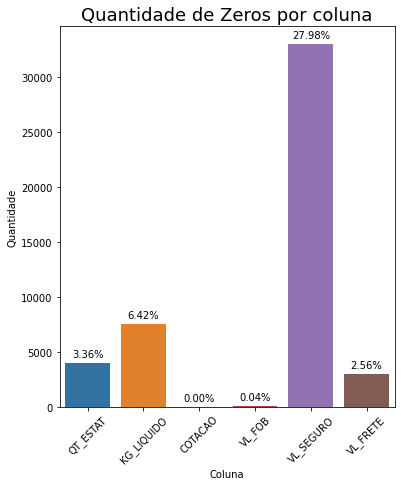

In [15]:
# Plotando a quantidade percentual de zeros de cada coluna do df_total em um gráfico
fig, ax =plt.subplots(figsize=(6,7))
sns.barplot(x=df_contador.Coluna, y = df_contador.Quantidade)
plt.title("Quantidade de Zeros por coluna", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.2f}%'.format((df_contador.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Substituindo os valroes 0 por 1 nas colunas QT_ESTAT, KG_LIQUIDO e VL_FOB no df_total
df_total['QT_ESTAT'] = df_total[['QT_ESTAT']].replace(0,1)
df_total['KG_LIQUIDO'] = df_total[['KG_LIQUIDO']].replace(0,1)
df_total['VL_FOB'] = df_total[['VL_FOB']].replace(0,1)

## Análise e Exploração dos Dados
---


### Análise das NCM importadas
-----


In [17]:
# Agrupando o valor FOB total por NCM
df = df_total.groupby(['NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada NCM no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

# Criando coluna extraindo somente o código da NCM com 8 dígitos
df["CO_NCM"] = df["NCM"].apply(lambda x: str(x)[:8])

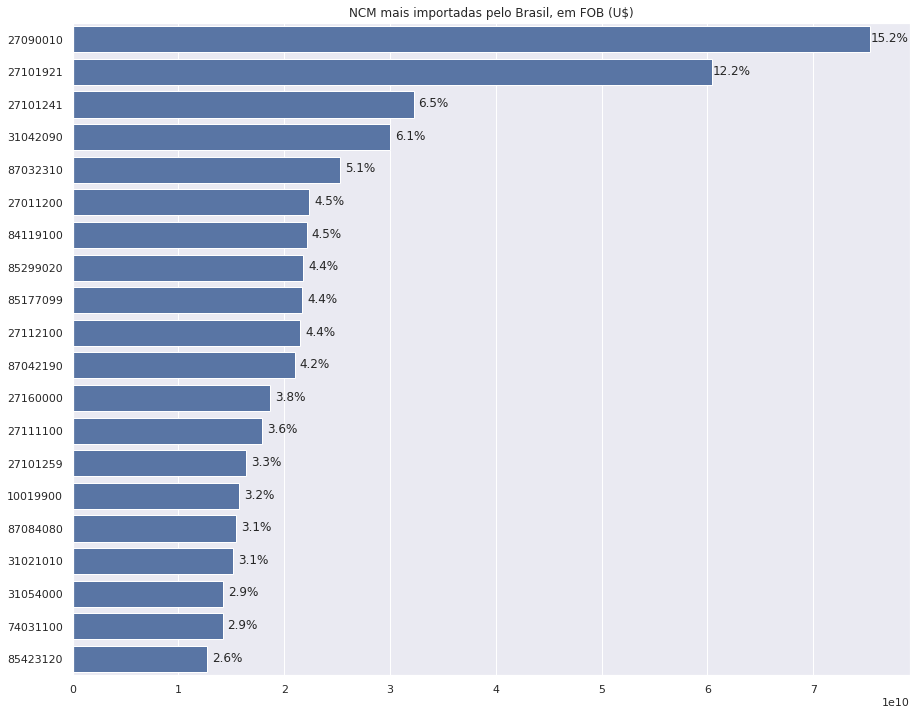

In [18]:
# Visualização das NCM pertencentes ao escopo
sns.set_theme(style="darkgrid")

# Inicializacao figura matplotlib
f, ax = plt.subplots(figsize=(15, 12))
bar = sns.barplot(x=list(df.VL_FOB)[:], y=list(df.CO_NCM)[:],
            label="Total", color="b")

  
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -12), 
                   textcoords = 'offset points')

    
ax.set_title("NCM mais importadas pelo Brasil, em FOB (U$)")
plt.show()

In [19]:
# Criando dataset, a partir do df_total, com as colunas da NCM e do valor do frete
df_dist_ncm = df_total[['NCM','VL_FRETE']]
df_dist_ncm["CO_NCM"] = df_dist_ncm["NCM"].apply(lambda x: str(x)[:8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


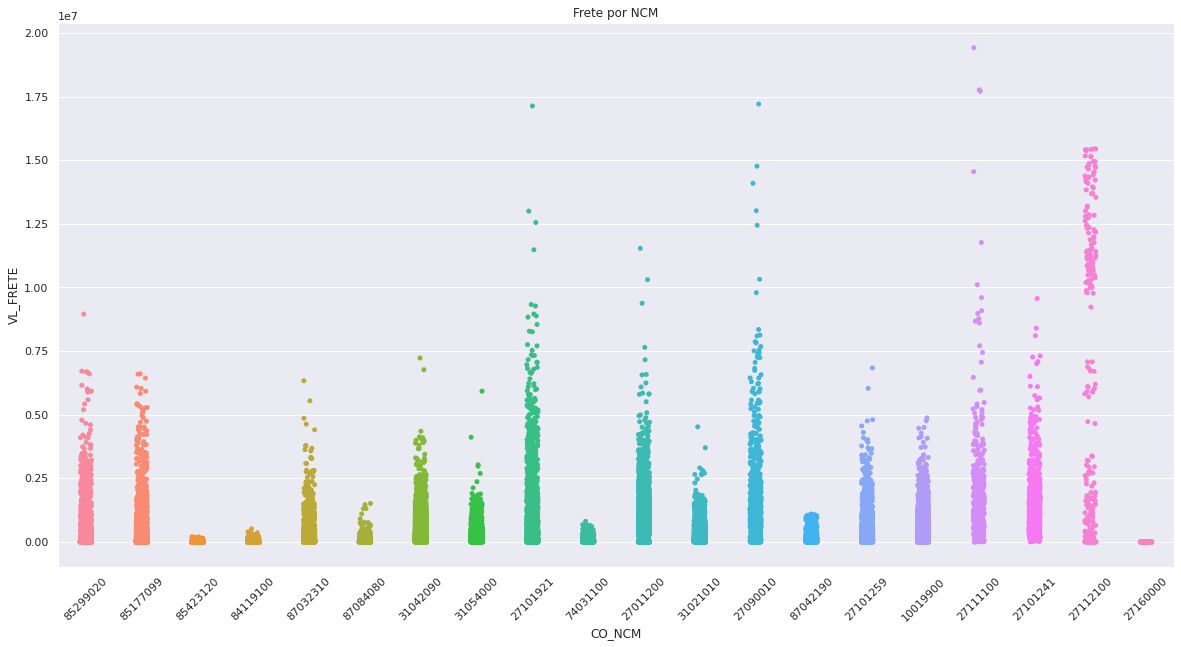

In [20]:
# Plotando gráfico de distribuição stripplot do valor do frete por cada NCM
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por NCM")
sns.stripplot(x='CO_NCM', y='VL_FRETE', data=df_dist_ncm, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

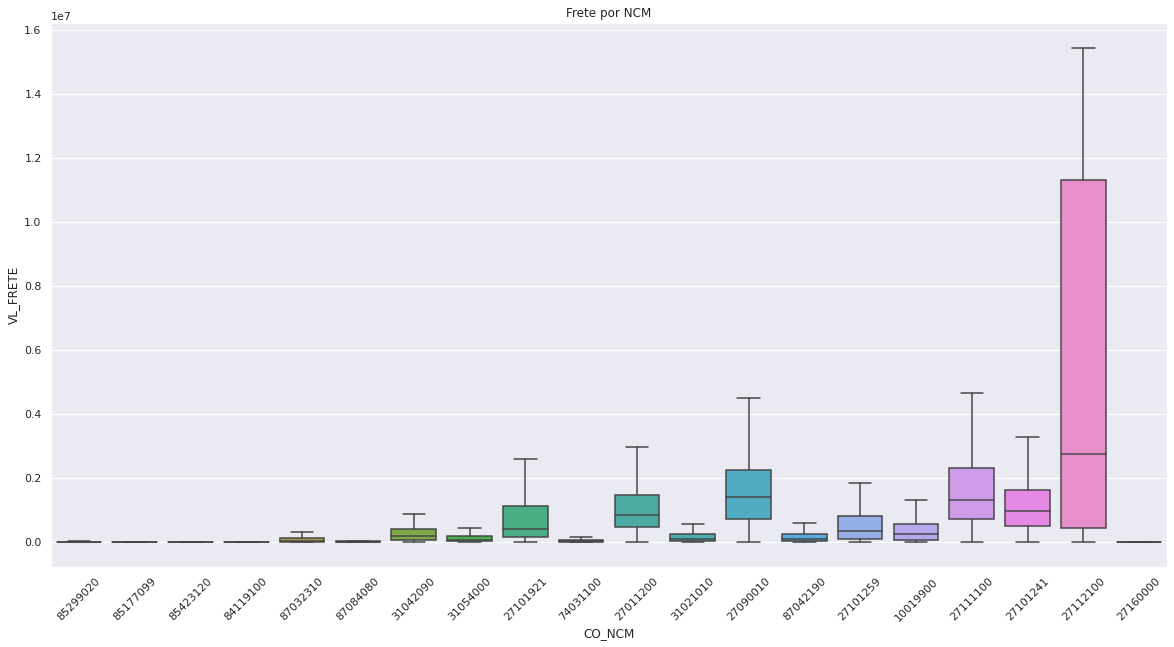

In [21]:
# Plotando gráfico de distribuição boxplot do valor do frete por cada NCM
fig, ax2 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por NCM")
sns.boxplot(x='CO_NCM', y='VL_FRETE', data=df_dist_ncm, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise das Unidades Estatísticas

In [22]:
# Criando dataset, a partir do df_total, com as colunas da NCM e código da unidade estatística
df_unidest = df_total[['NCM','CO_UNID']]
df_unidest["NCM"] = df_unidest["NCM"].apply(lambda x: str(x)[:8])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


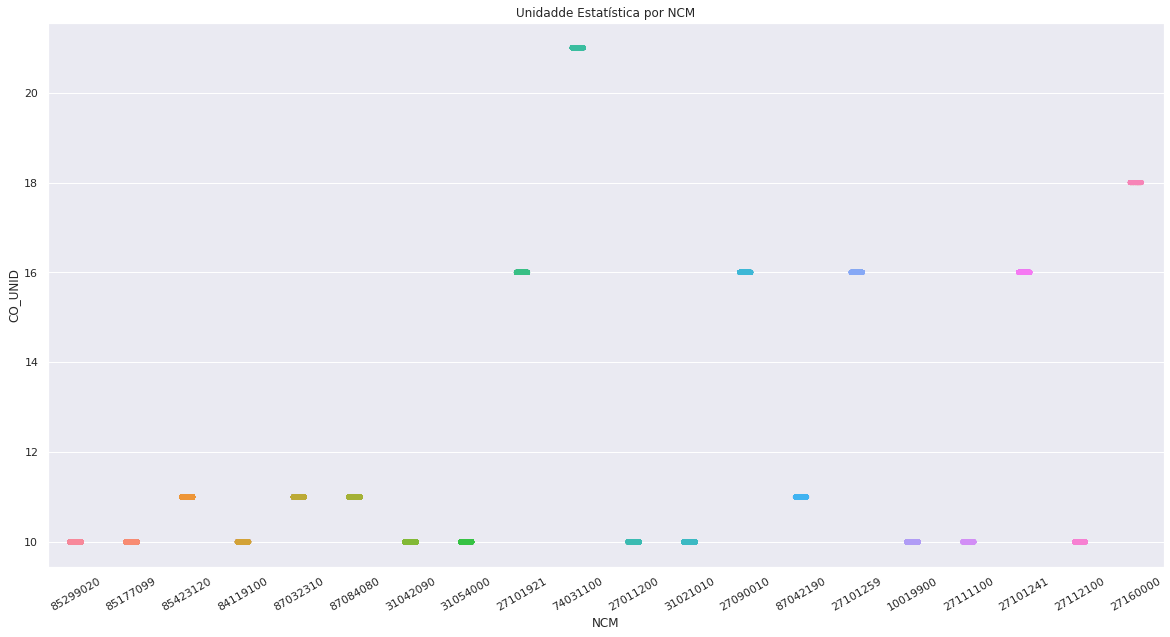

In [23]:
# Plotando gráfico de distribuição stripplot da unidade estatística por cada NCM
fig, ax = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Unidadde Estatística por NCM")
sns.stripplot(x='NCM', y='CO_UNID', data=df_unidest)
plt.xticks(rotation=30)
plt.show()

In [24]:
# Contando a quantidade de vezes e o percentual que cada unidade estatística aparece no df_total
df_contador = df_unidest['CO_UNID'].value_counts()
df_contador = pd.DataFrame({'CO_UNID':df_contador.index, 'Quantidade':df_contador.values})
df_contador['porcentagem'] = df_contador.Quantidade.apply(lambda x: x/quant_total)*100
df_contador

,CO_UNID,Quantidade,porcentagem
0,10,72671,61.682822
1,11,38187,32.412956
2,16,5189,4.404400
3,21,1496,1.269798
4,18,271,0.230024


In [25]:
# Removendo as colunas CO_UNID e QT_ESTAT do df_total
df_total.drop(['CO_UNID','QT_ESTAT'],axis=1,inplace=True)

In [26]:
# Exibindo o cabeçalho do df_total
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,Hong Kong,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",Hong Kong,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",Hong Kong,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


### Análise dos Países Exportadores
-----


In [27]:
# Verificando a quantidade de países distintos que aparecem no dataset df_total
qt_paises = df_total[['NO_PAIS']].nunique()
qt_paises

NO_PAIS    165
dtype: int64

In [28]:
# Agrupando o valor FOB total por país exportador
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada país exportador no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

In [29]:
# Verificando o percentual que os países selecionados representam do valor FOB total
fob_total = df.VL_FOB.sum()
maiores_paises = df.iloc[:37,:]
fob_maiores_paises = maiores_paises.VL_FOB.sum()
perc_paises = fob_maiores_paises/fob_total
print(f'O percentual que esses países representam no valor FOB é de {perc_paises:.1%}')

O percentual que esses países representam no valor FOB é de 95.4%


In [30]:
df_total.NO_PAIS = df_total.NO_PAIS.apply(lambda x : 'OUTROS' if x not in list(maiores_paises.NO_PAIS) else x)

In [31]:
df_total

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.050600,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.050600,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.050600,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.050600,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.050600,72146,8,1328
...,...,...,...,...,...,...,...,...,...,...,...,...
117809,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,PR,RODOVIARIA,0910651 - GUAIRA,156000,1.717316,31668,0,312
117810,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,PR,RODOVIARIA,0910652 - SANTA HELENA,1500000,1.717316,270000,0,7500
117811,2012,2,10019900 - Outros trigos e misturas de trigo c...,Paraguai,MS,RODOVIARIA,0145100 - MUNDO NOVO,320340,1.717316,69834,0,3844
117812,2012,2,27112100 - Gás natural no estado gasoso,Bolívia,MS,CONDUTO/REDE DE TRANSMISSAO,0145200 - CORUMBA,468795053,1.717316,204558151,0,11544398


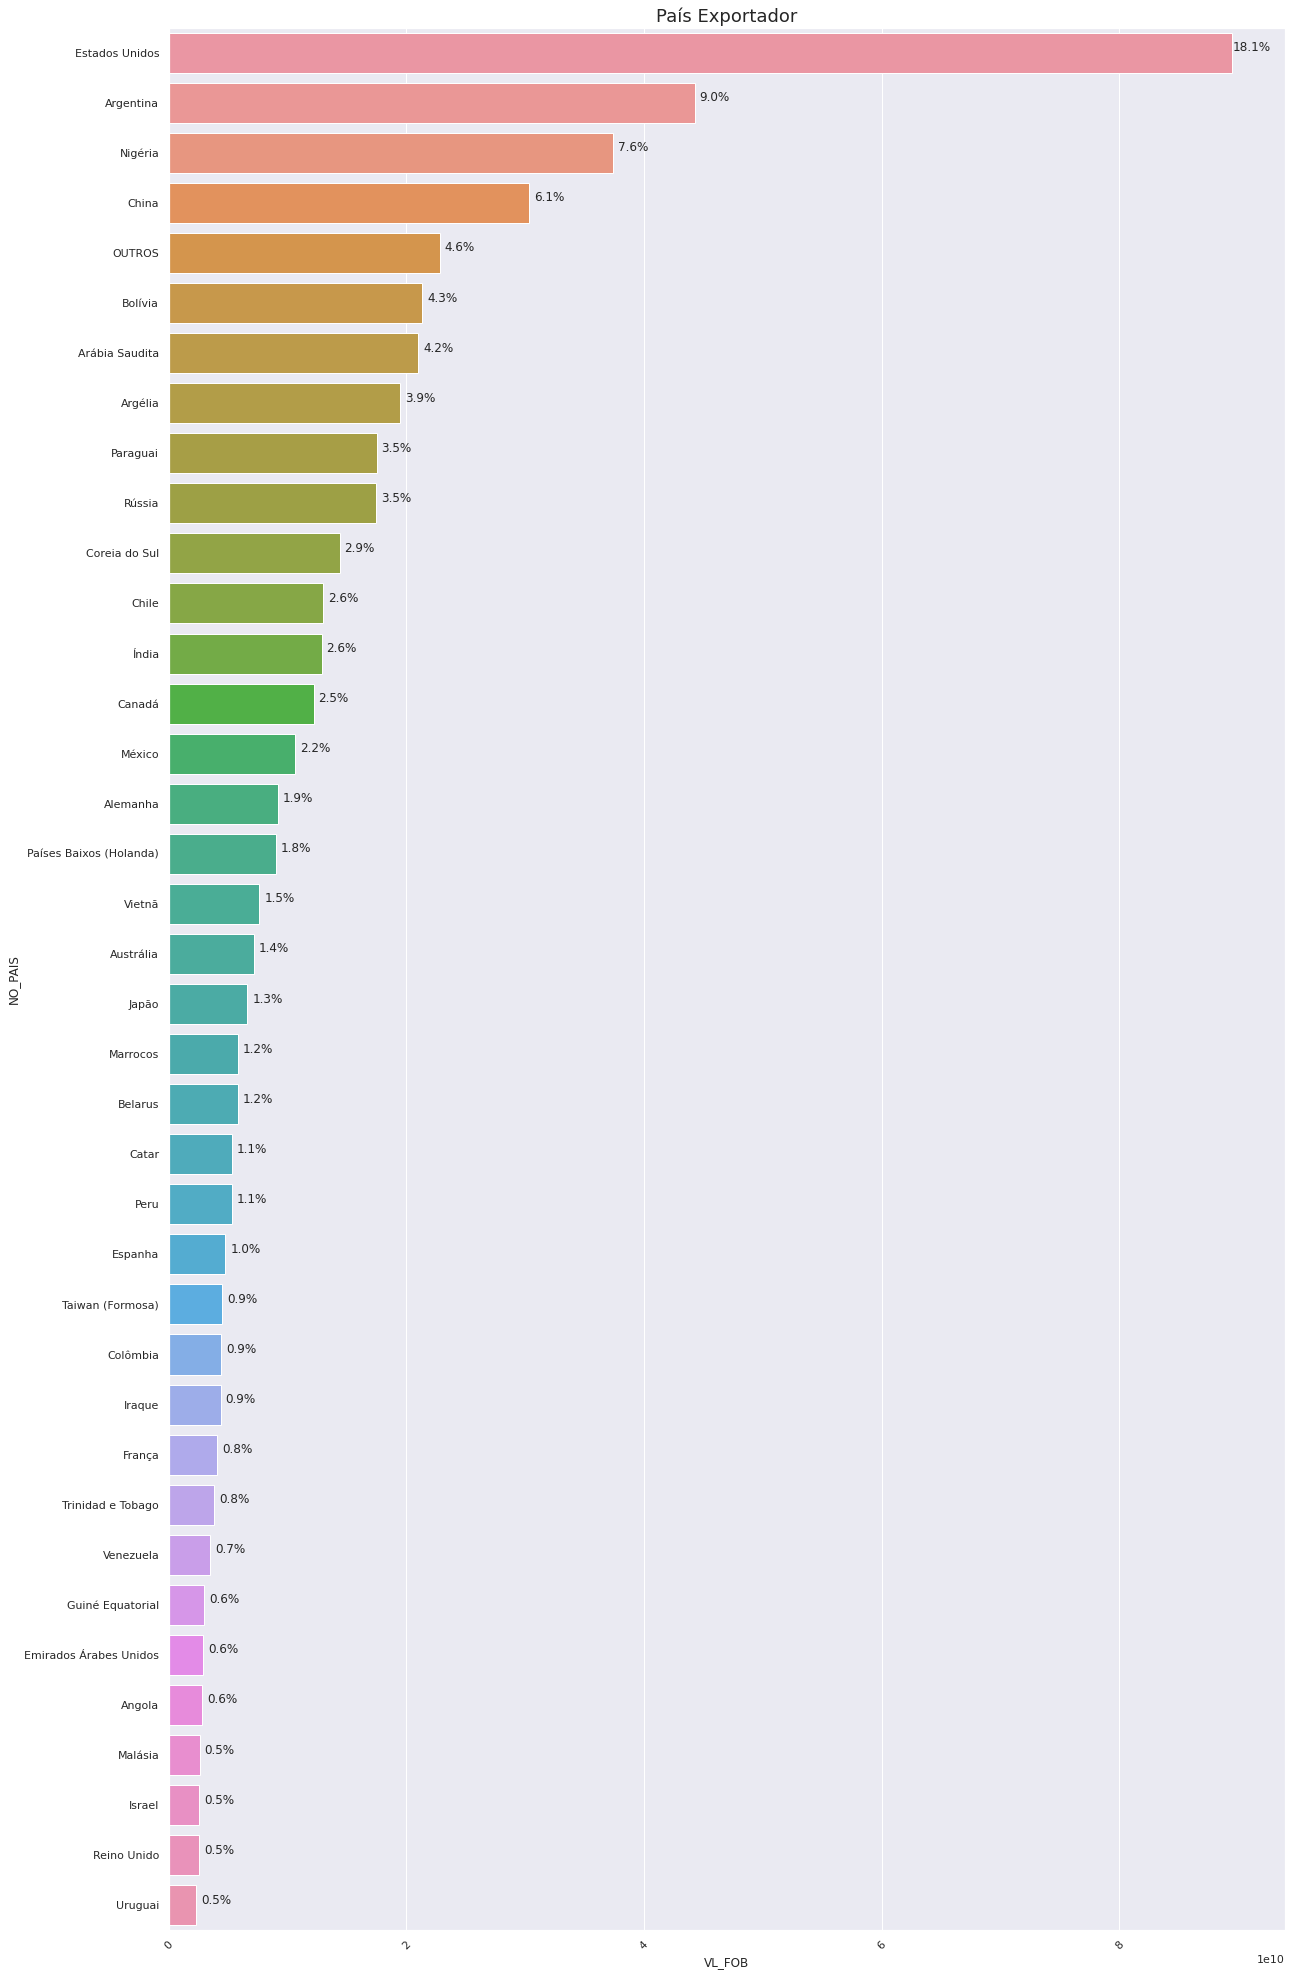

In [32]:
df = df_total.groupby(['NO_PAIS']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,35))
sns.barplot(y=df['NO_PAIS'], x = df['VL_FOB'])
plt.title("País Exportador", fontsize=18)

for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (20, -15), 
                   textcoords = 'offset points')


plt.xticks(rotation=45)
plt.show()

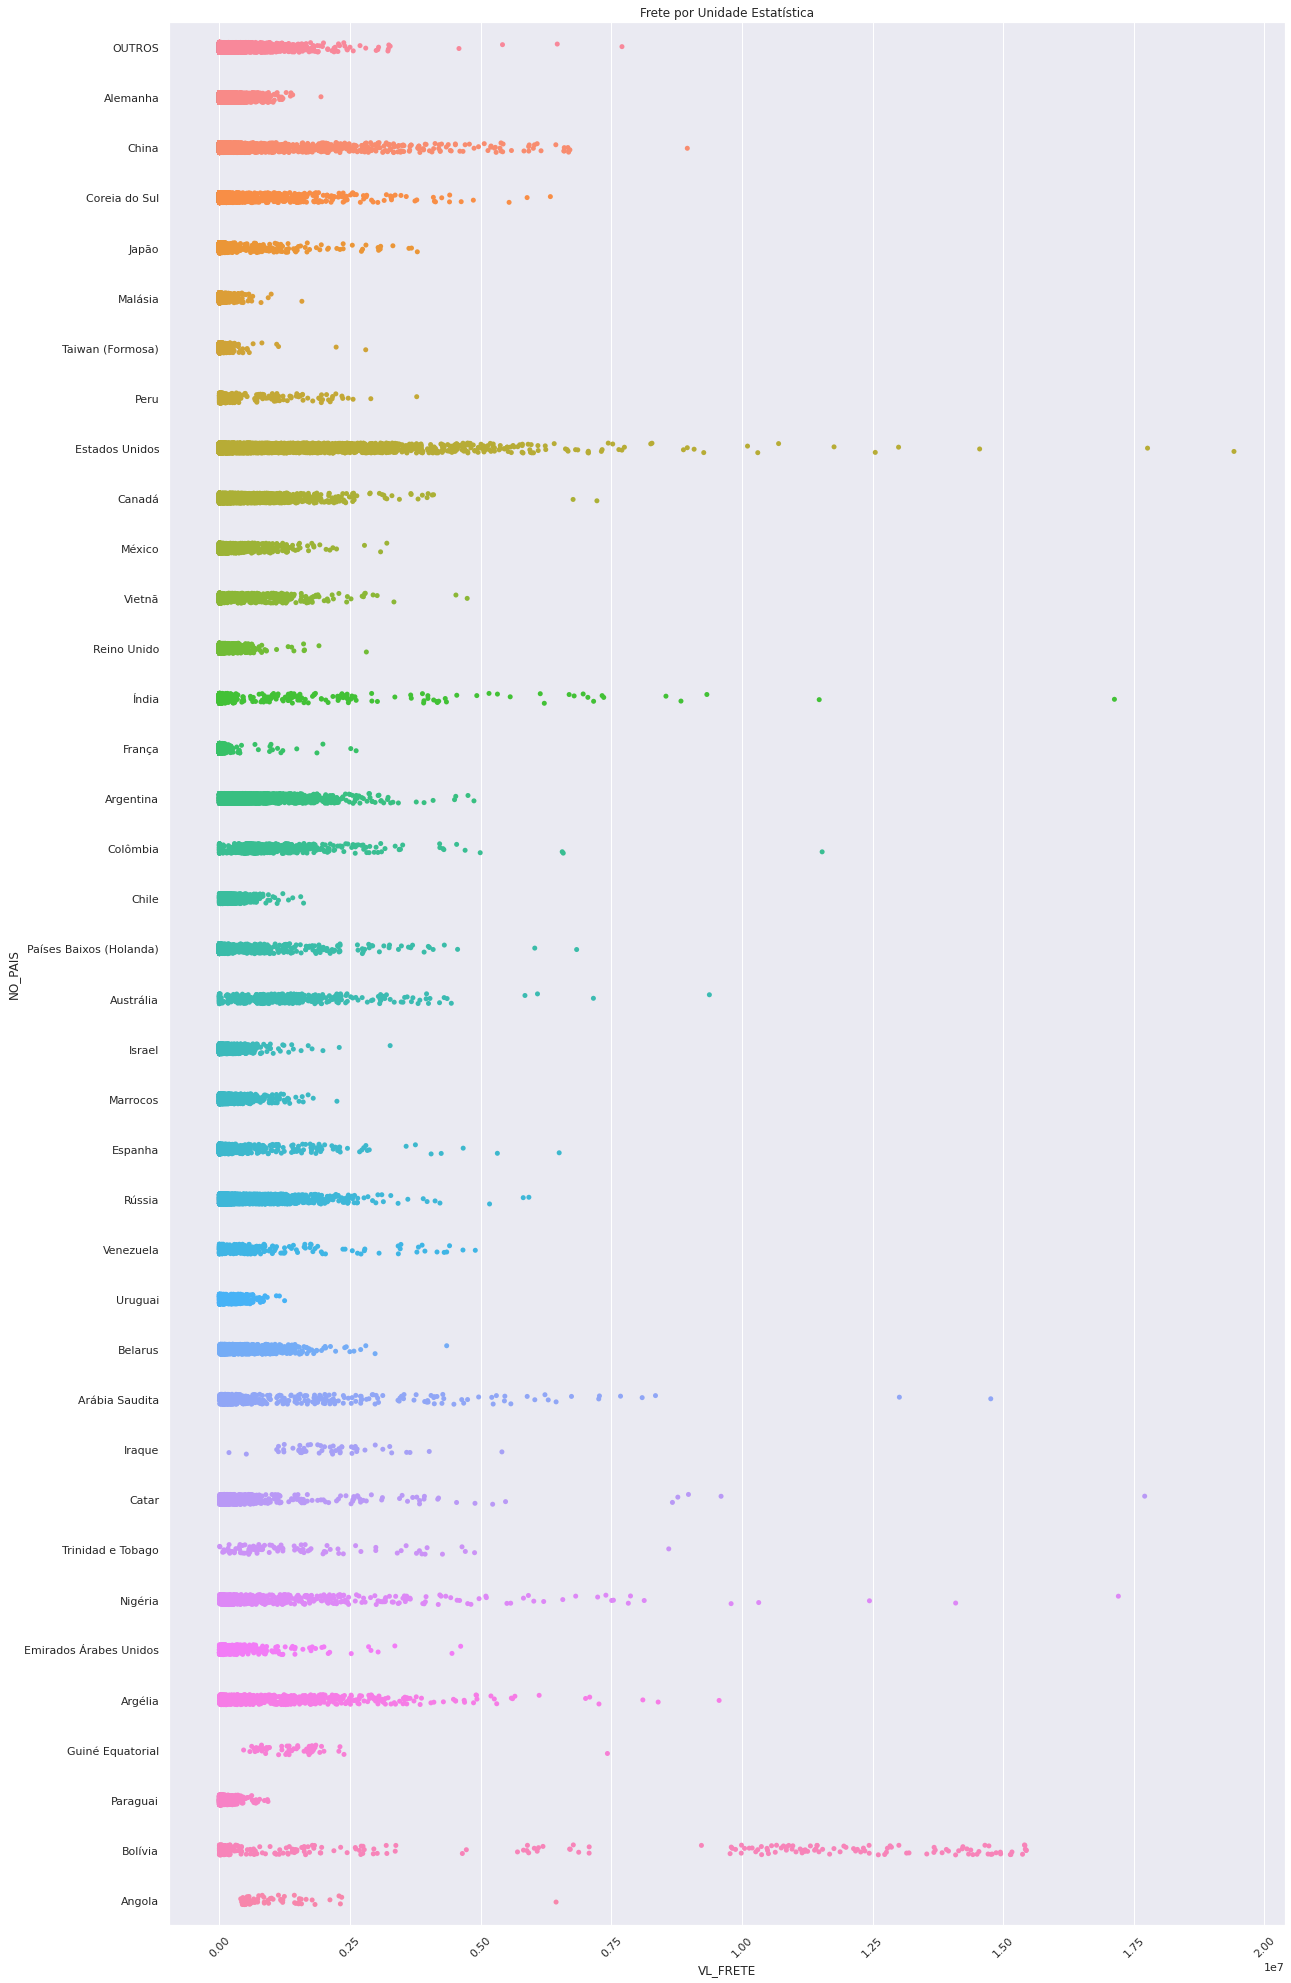

In [33]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,35))
plt.title("Frete por Unidade Estatística")
sns.stripplot(y='NO_PAIS', x='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

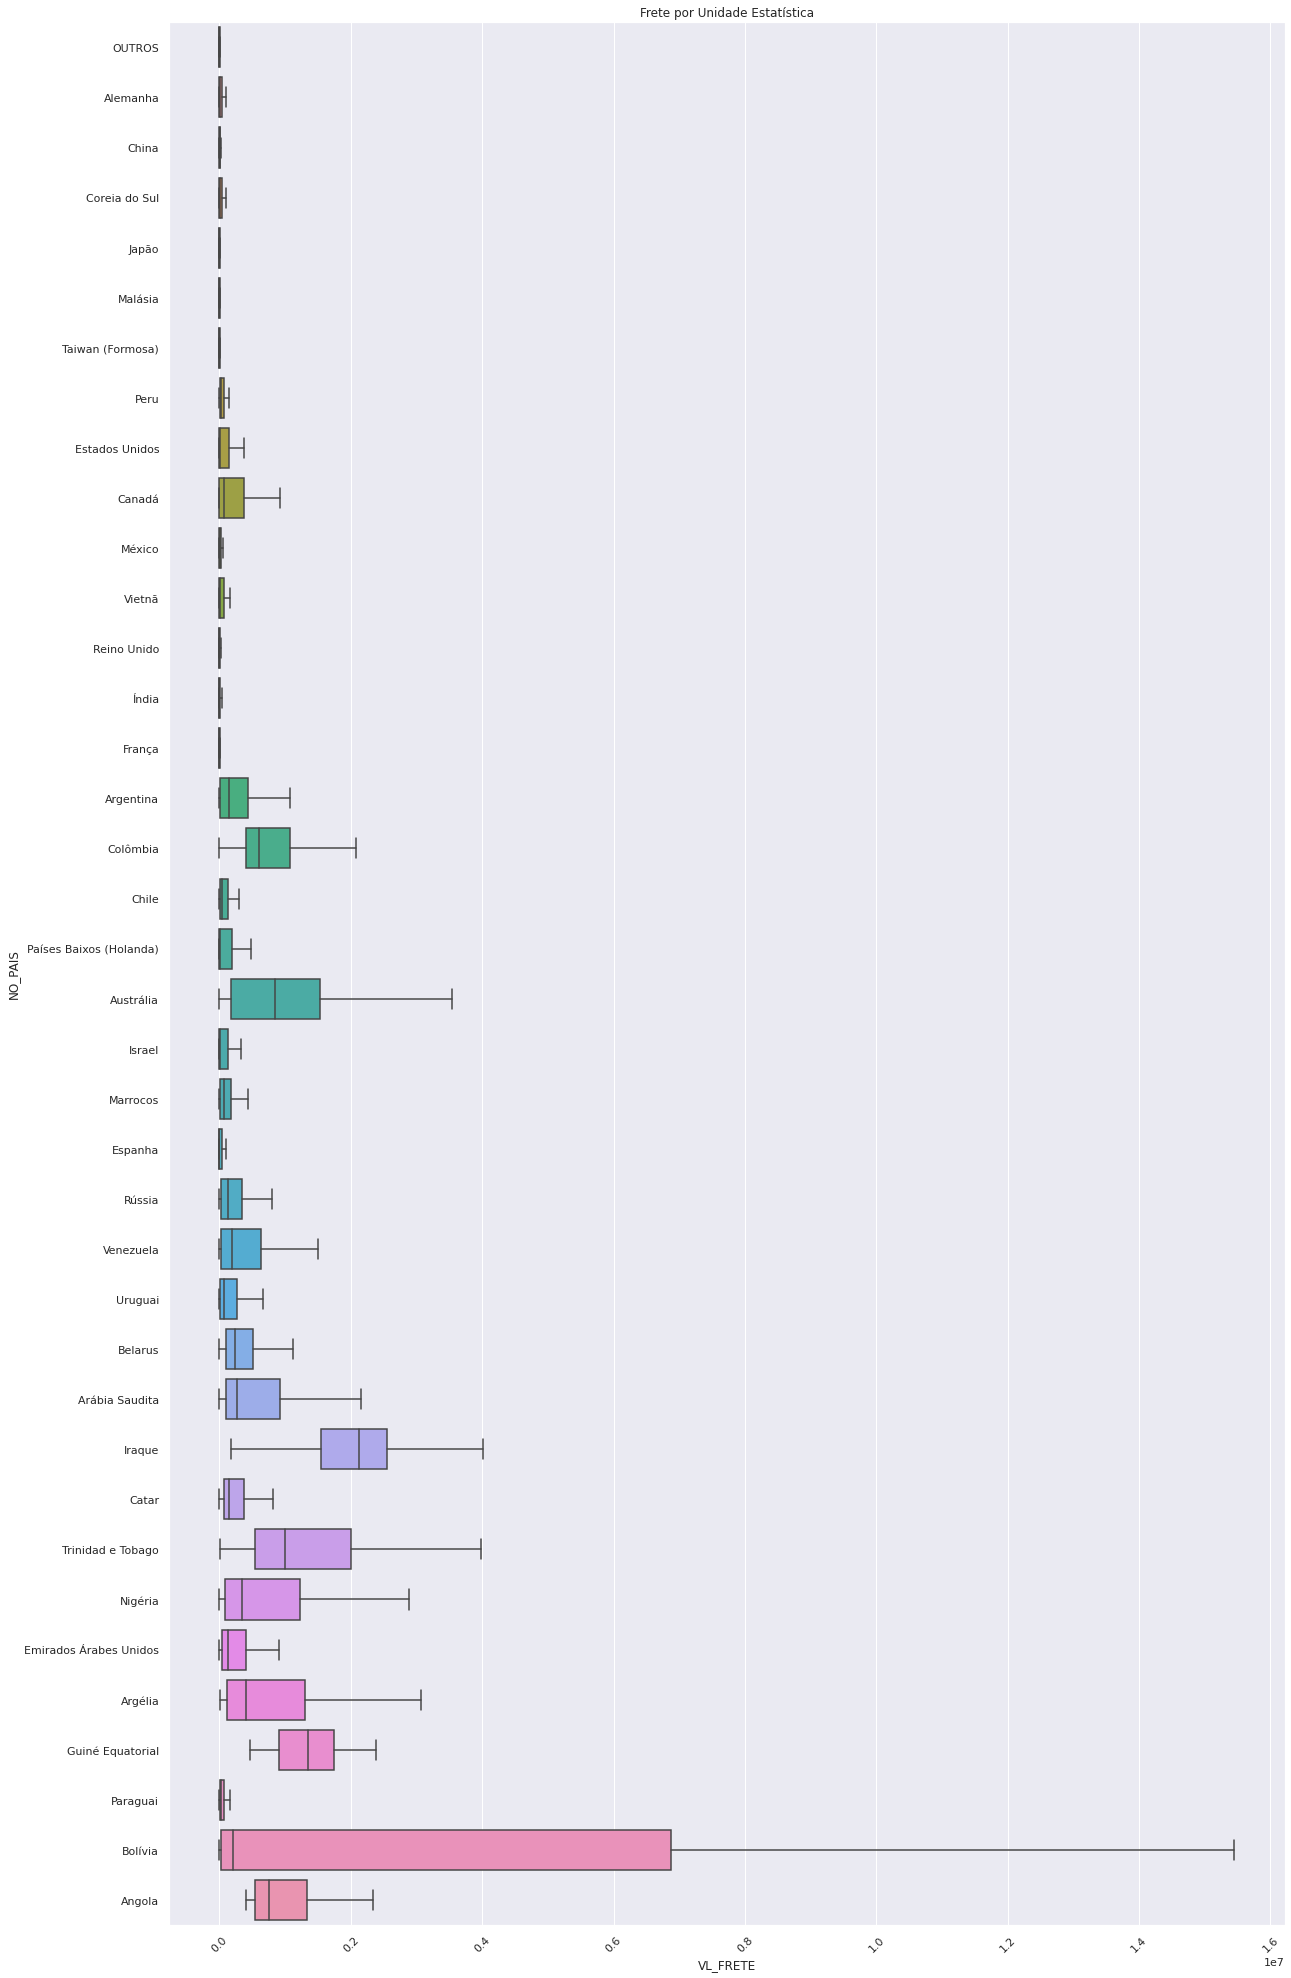

In [34]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,35))
plt.title("Frete por Unidade Estatística")
sns.boxplot(y='NO_PAIS', x='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise dos Estados de Destino das Mercadorias
-----


In [35]:
# Verificando a quantidade de países distintos que aparecem no dataset df_total
qt_uf = df_total[['SG_UF_NCM']].nunique()
qt_uf

SG_UF_NCM    29
dtype: int64

In [36]:
# Agrupando o valor FOB total por estado de destino
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]

# Criando coluna que indica o percentual de participação de cada estado de destino no valor FOB total
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)


In [37]:
# Verificando o percentual que os países selecionados representam do valor FOB total
fob_total = df.VL_FOB.sum()
maiores_destinos = df.iloc[:15,:]
fob_maiores_destinos = maiores_destinos.VL_FOB.sum()
perc_destinos = fob_maiores_destinos/fob_total
print(f'O percentual que esses destinos representam no valor FOB é de {perc_destinos:.1%}')

O percentual que esses destinos representam no valor FOB é de 96.6%


In [38]:
df_total.SG_UF_NCM = df_total.SG_UF_NCM.apply(lambda x : 'OUTROS' if x not in list(maiores_destinos.SG_UF_NCM) else x)

In [39]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


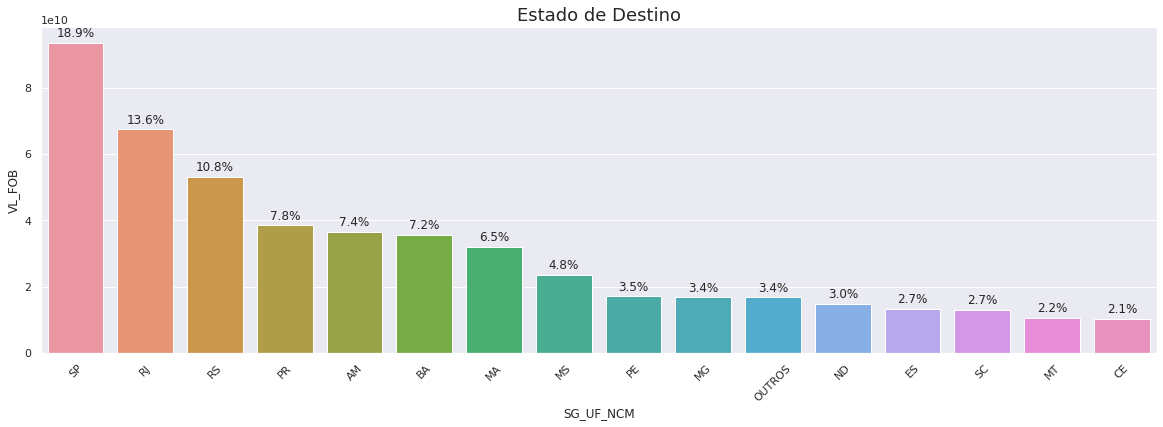

In [40]:
df = df_total.groupby(['SG_UF_NCM']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,6))
sns.barplot(x=df['SG_UF_NCM'], y = df['VL_FOB'])
plt.title("Estado de Destino", fontsize=18)
for i,p in enumerate(ax.patches):
   ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', 
                  xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

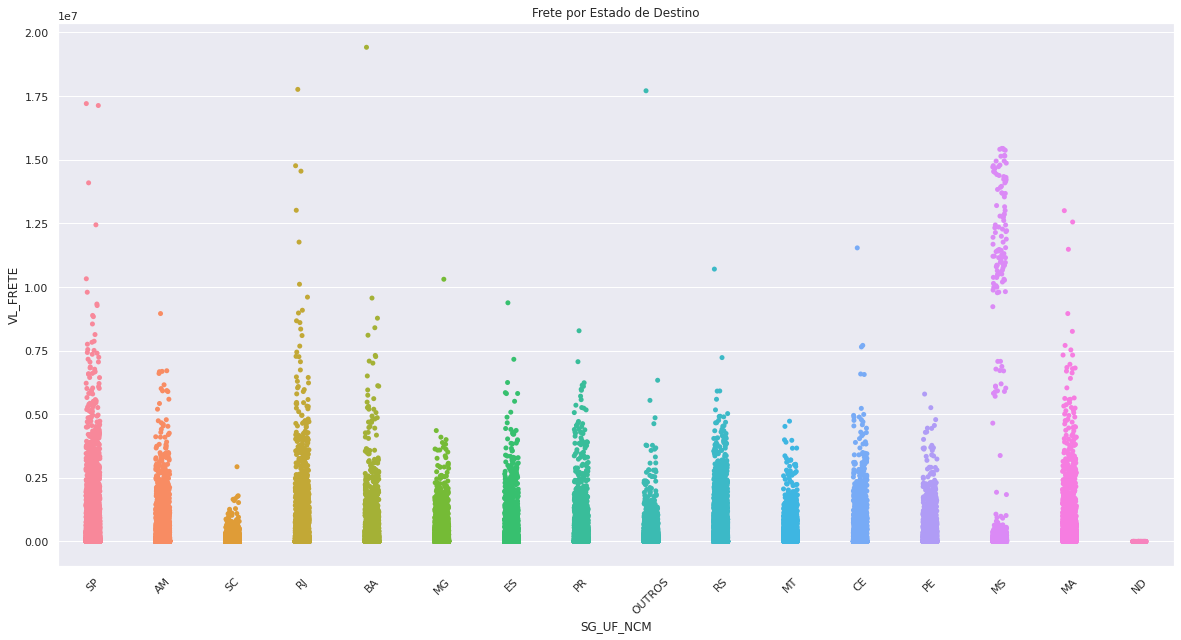

In [41]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.stripplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

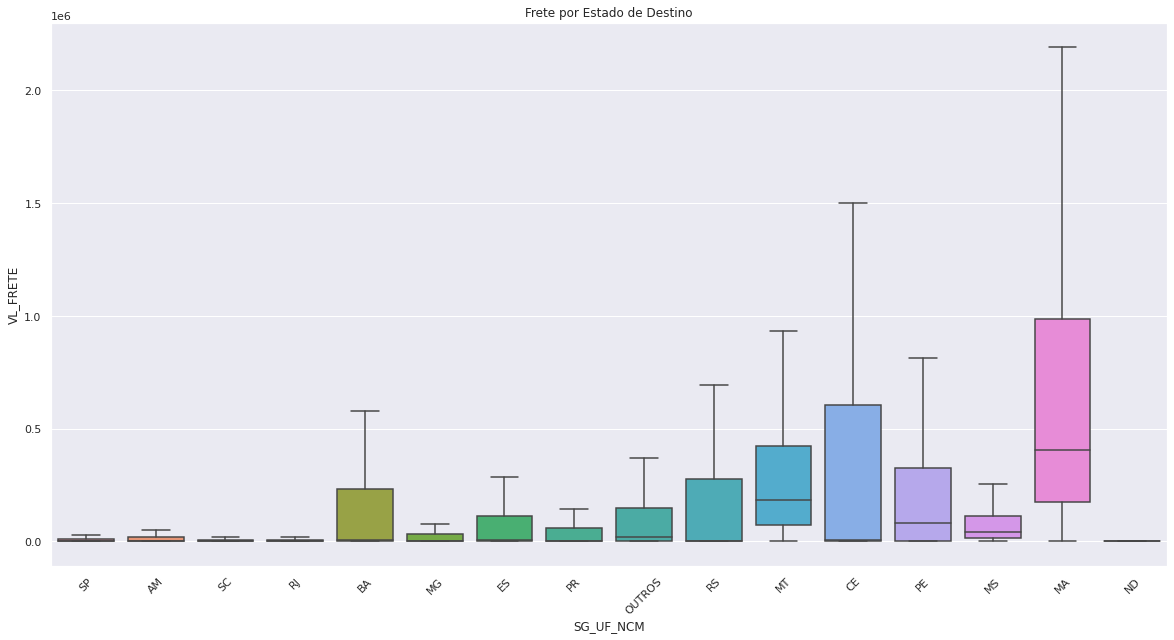

In [42]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,10))
plt.title("Frete por Estado de Destino")
sns.boxplot(x='SG_UF_NCM', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da Via de Transporte
-----


In [43]:
# Verificando a quantidade de vias de transporte distintas que aparecem no dataset df_total
qt_via = df_total[['NO_VIA']].nunique()
qt_via

NO_VIA    9
dtype: int64

In [44]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)


In [45]:
fob_total = df.VL_FOB.sum()
maiores_vias = df.iloc[:3,:]
fob_maiores_vias = maiores_vias.VL_FOB.sum()
perc_vias = fob_maiores_vias/fob_total
print(f'O percentual que essas vias de transporte representam no valor FOB é de {perc_vias:.1%}')

O percentual que essas vias de transporte representam no valor FOB é de 97.0%


In [46]:
df_total.NO_VIA = df_total.NO_VIA.apply(lambda x : 'OUTROS' if x not in list(maiores_vias.NO_VIA) else x)

In [47]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


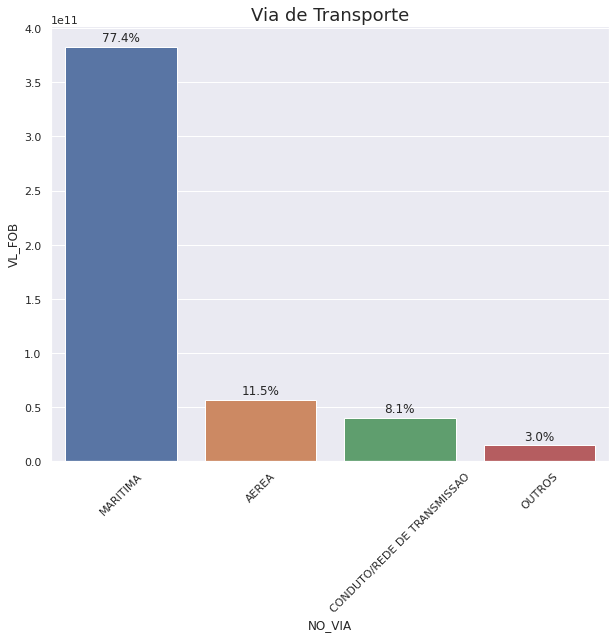

In [48]:
df = df_total.groupby(['NO_VIA']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(10,8))
sns.barplot(x=df['NO_VIA'], y = df['VL_FOB'])
plt.title("Via de Transporte", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

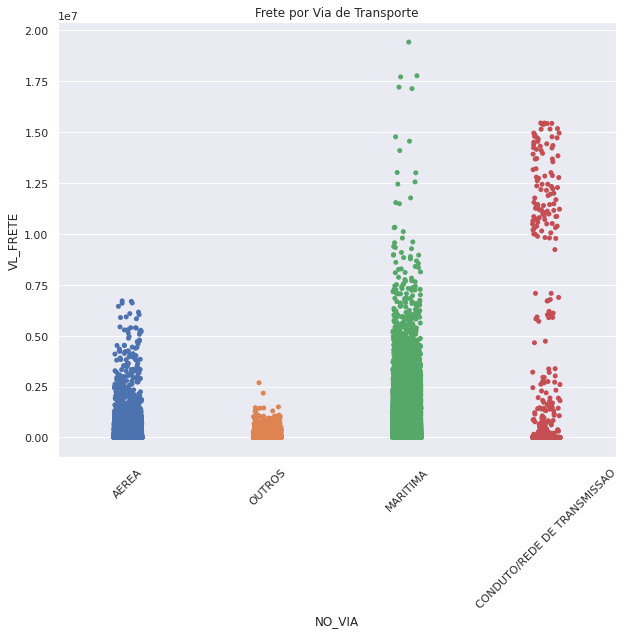

In [49]:
fig, ax1 = plt.subplots(sharey=False, figsize=(10,8))
plt.title("Frete por Via de Transporte")
sns.stripplot(x='NO_VIA', y='VL_FRETE', data=df_total, ax=ax1)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

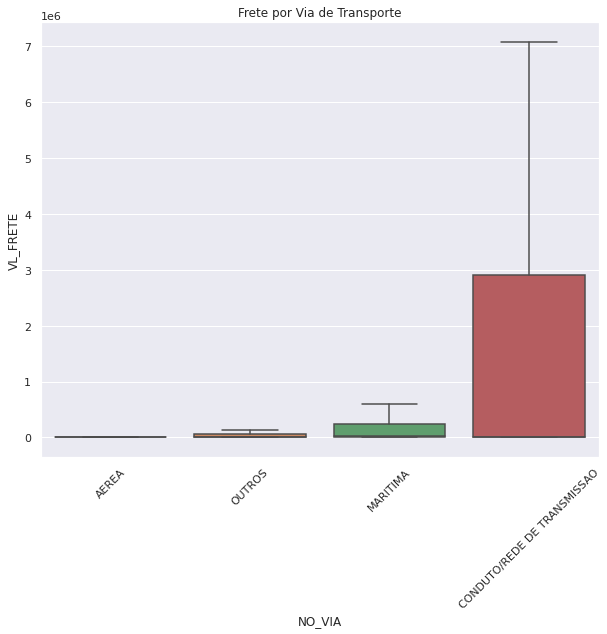

In [50]:
fig, ax2 = plt.subplots(sharey=False, figsize=(10,8))
plt.title("Frete por Via de Transporte")
sns.boxplot(x='NO_VIA', y='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
plt.xticks(rotation=45)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise da URF de Desembaraço


In [51]:
# Verificando a quantidade de unidades de desembaraço distintas que aparecem no dataset df_total
qt_urf = df_total[['NO_URF']].nunique()
qt_urf

NO_URF    108
dtype: int64

In [52]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

In [53]:
fob_total = df.VL_FOB.sum()
maiores_urf = df.iloc[:30,:]
fob_maiores_urf = maiores_urf.VL_FOB.sum()
perc_urf = fob_maiores_urf/fob_total
print(f'O percentual que essas unidades representam no valor FOB é de {perc_urf:.1%}')

O percentual que essas unidades representam no valor FOB é de 95.7%


In [54]:
df_total.NO_URF = df_total.NO_URF.apply(lambda x : 'OUTROS' if x not in list(maiores_urf.NO_URF) else x)

In [59]:
df_total.head()

,CO_ANO,CO_MES,NCM,NO_PAIS,SG_UF_NCM,NO_VIA,NO_URF,KG_LIQUIDO,COTACAO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,6,85299020 - Outras partes para aparelhos recept...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,35,2.0506,3252,3,538
1,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,356,2.0506,44496,40,6150
2,2012,6,85177099 - Outras partes para aparelhos de tel...,OUTROS,AM,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,82,2.0506,116919,82,1334
3,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SC,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,120,2.0506,22194,46,1861
4,2012,6,"85423120 - Processadores e controladores, mesm...",OUTROS,SP,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,96,2.0506,72146,8,1328


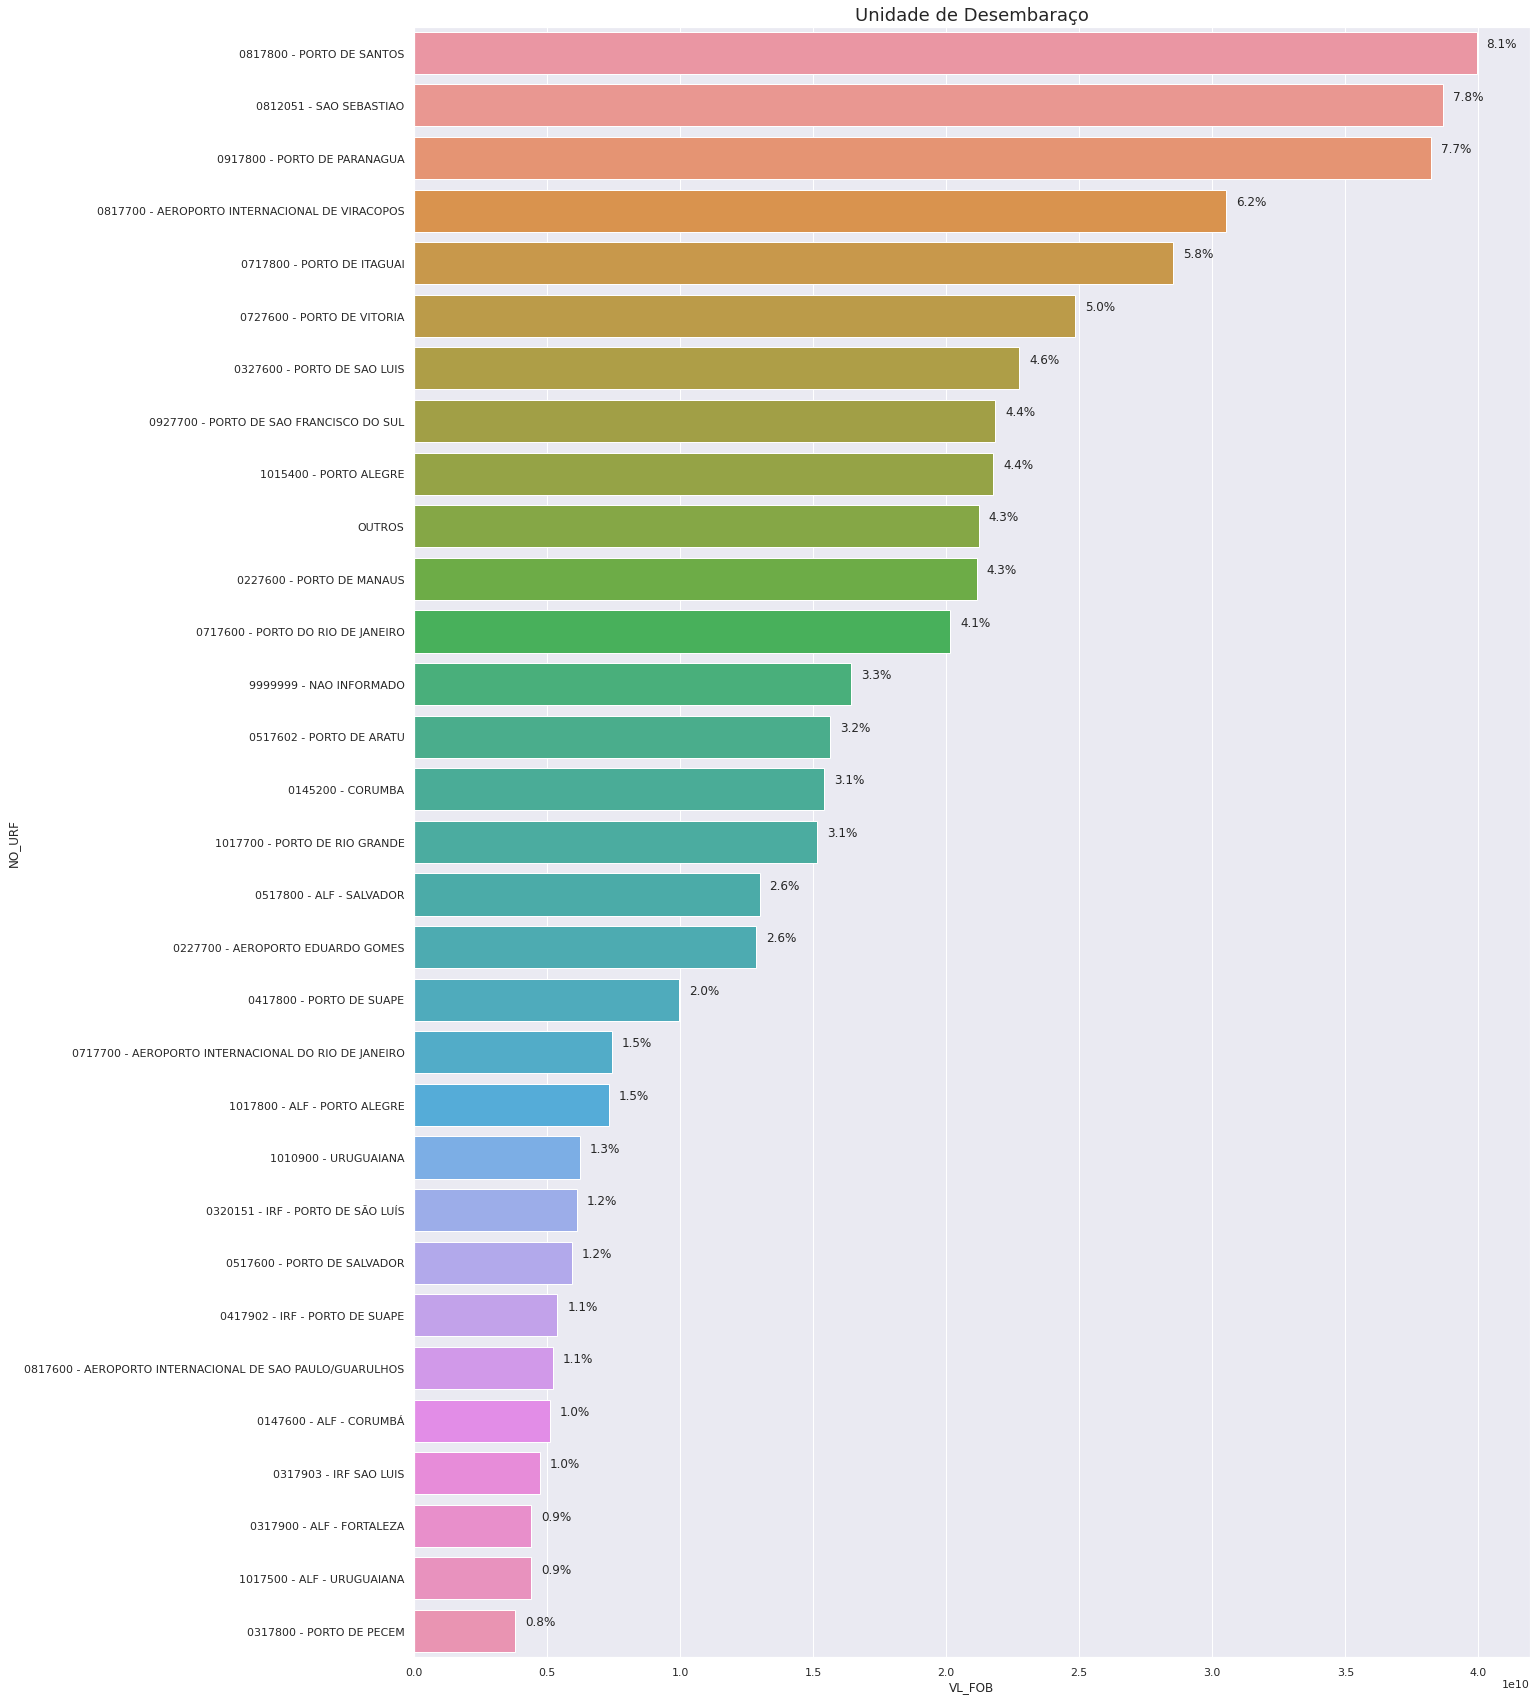

In [55]:
df = df_total.groupby(['NO_URF']).sum().sort_values(by=['VL_FOB'],ascending=False)
df = df[['VL_FOB']]
fob_total = df.VL_FOB.sum()
df['porcentagem'] = df.VL_FOB.apply(lambda x: x/fob_total)
df.reset_index(inplace=True)

fig, ax =plt.subplots(figsize=(20,30))
sns.barplot(y=df['NO_URF'], x = df['VL_FOB'])
plt.title("Unidade de Desembaraço", fontsize=18)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.1f}%'.format((df.porcentagem[i])*100), 
                   (p.get_width() + p.get_x(), p.get_y()), 
                   ha = 'center', va = 'center', 
                   xytext = (25, -12), 
                   textcoords = 'offset points')

plt.show()
#plt.savefig('imagens/tipoCE.png',bbox_inches='tight')

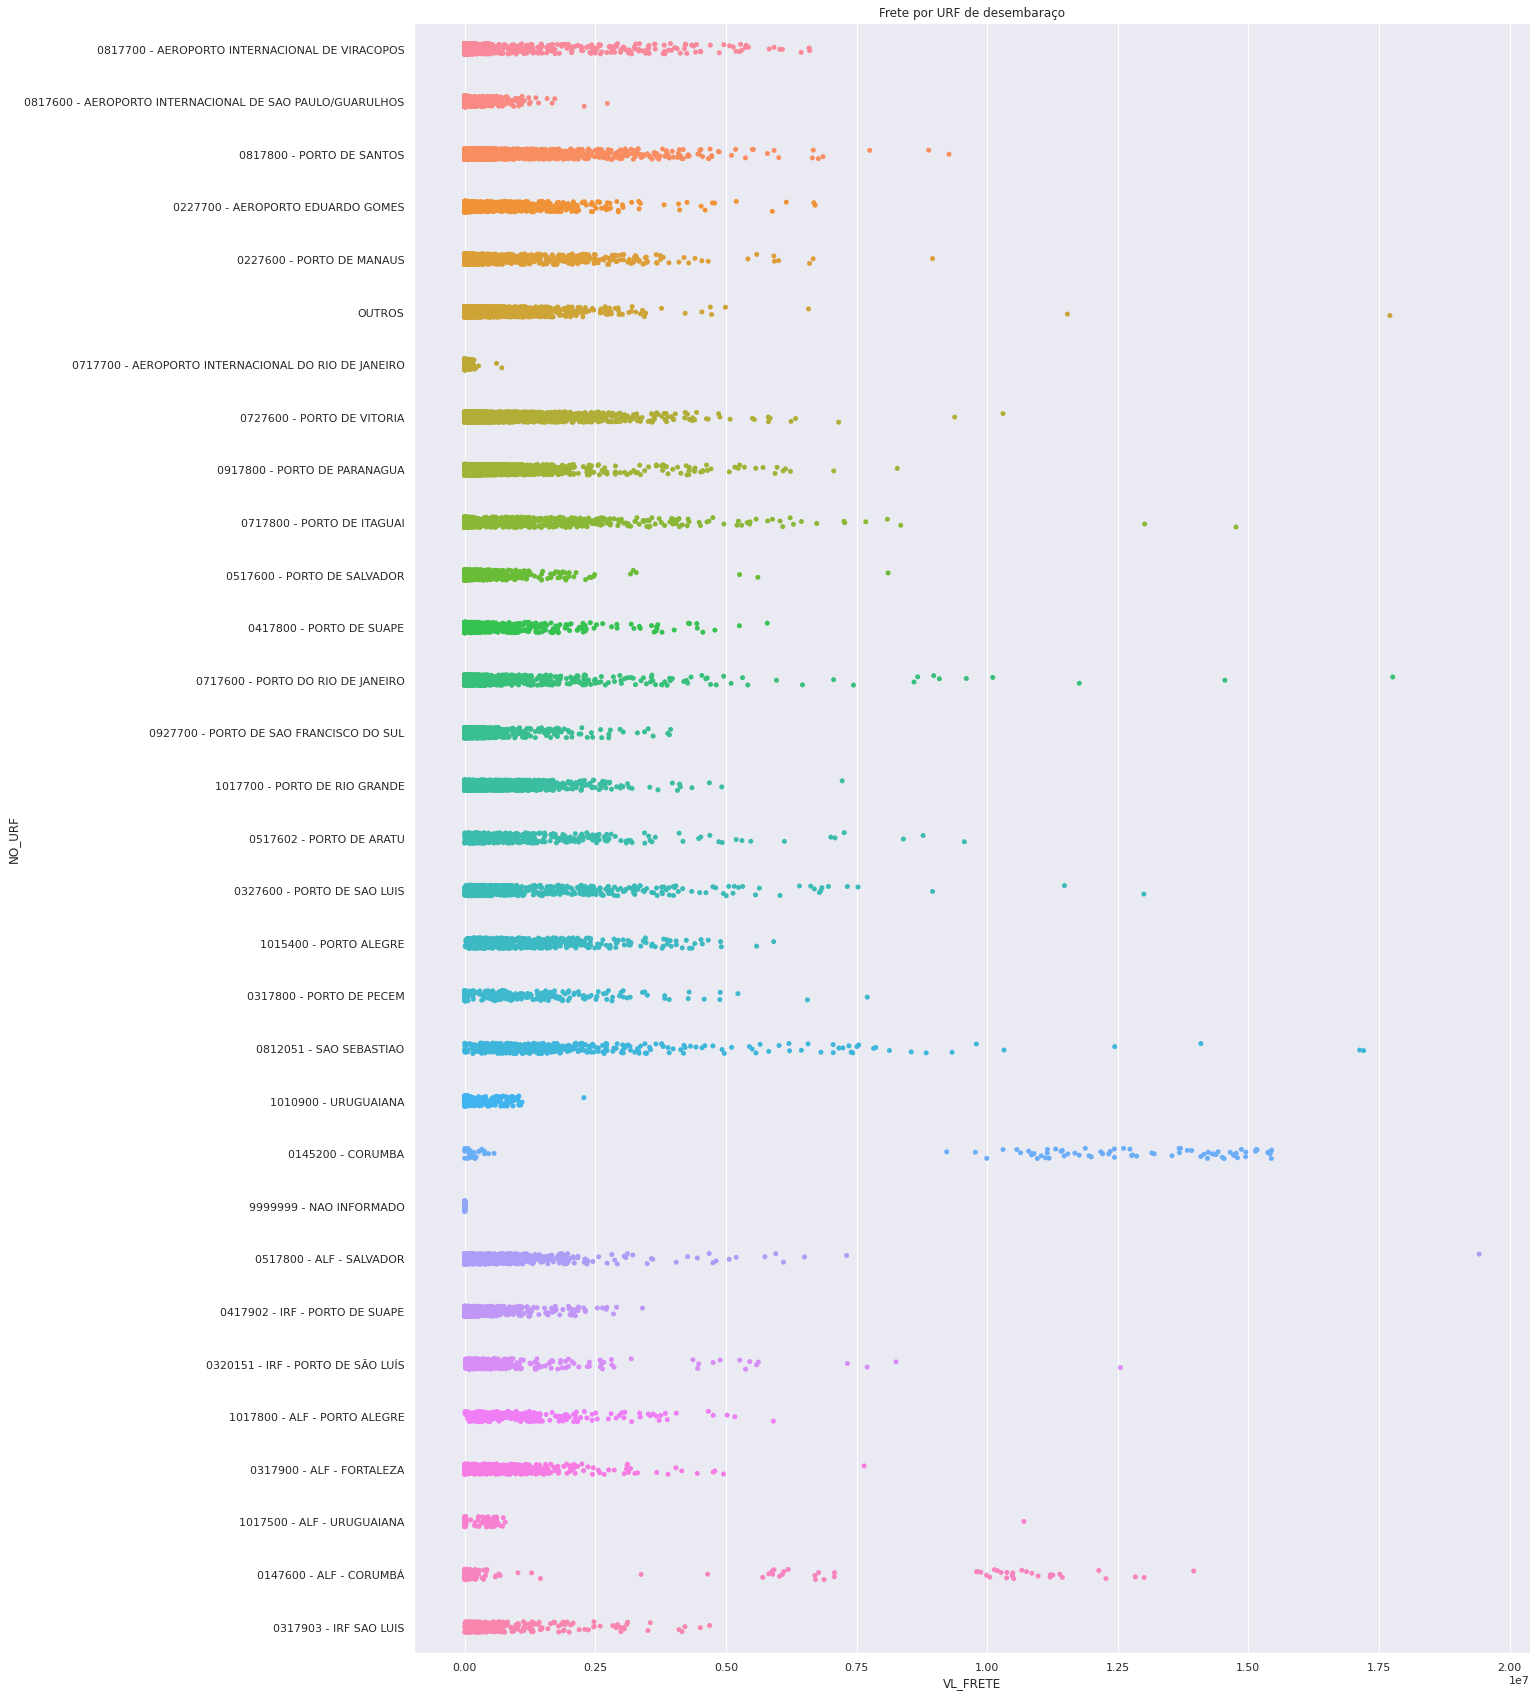

In [56]:
fig, ax1 = plt.subplots(sharey=False, figsize=(20,30))
plt.title("Frete por URF de desembaraço")
sns.stripplot(y='NO_URF', x='VL_FRETE', data=df_total, ax=ax1)
#plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

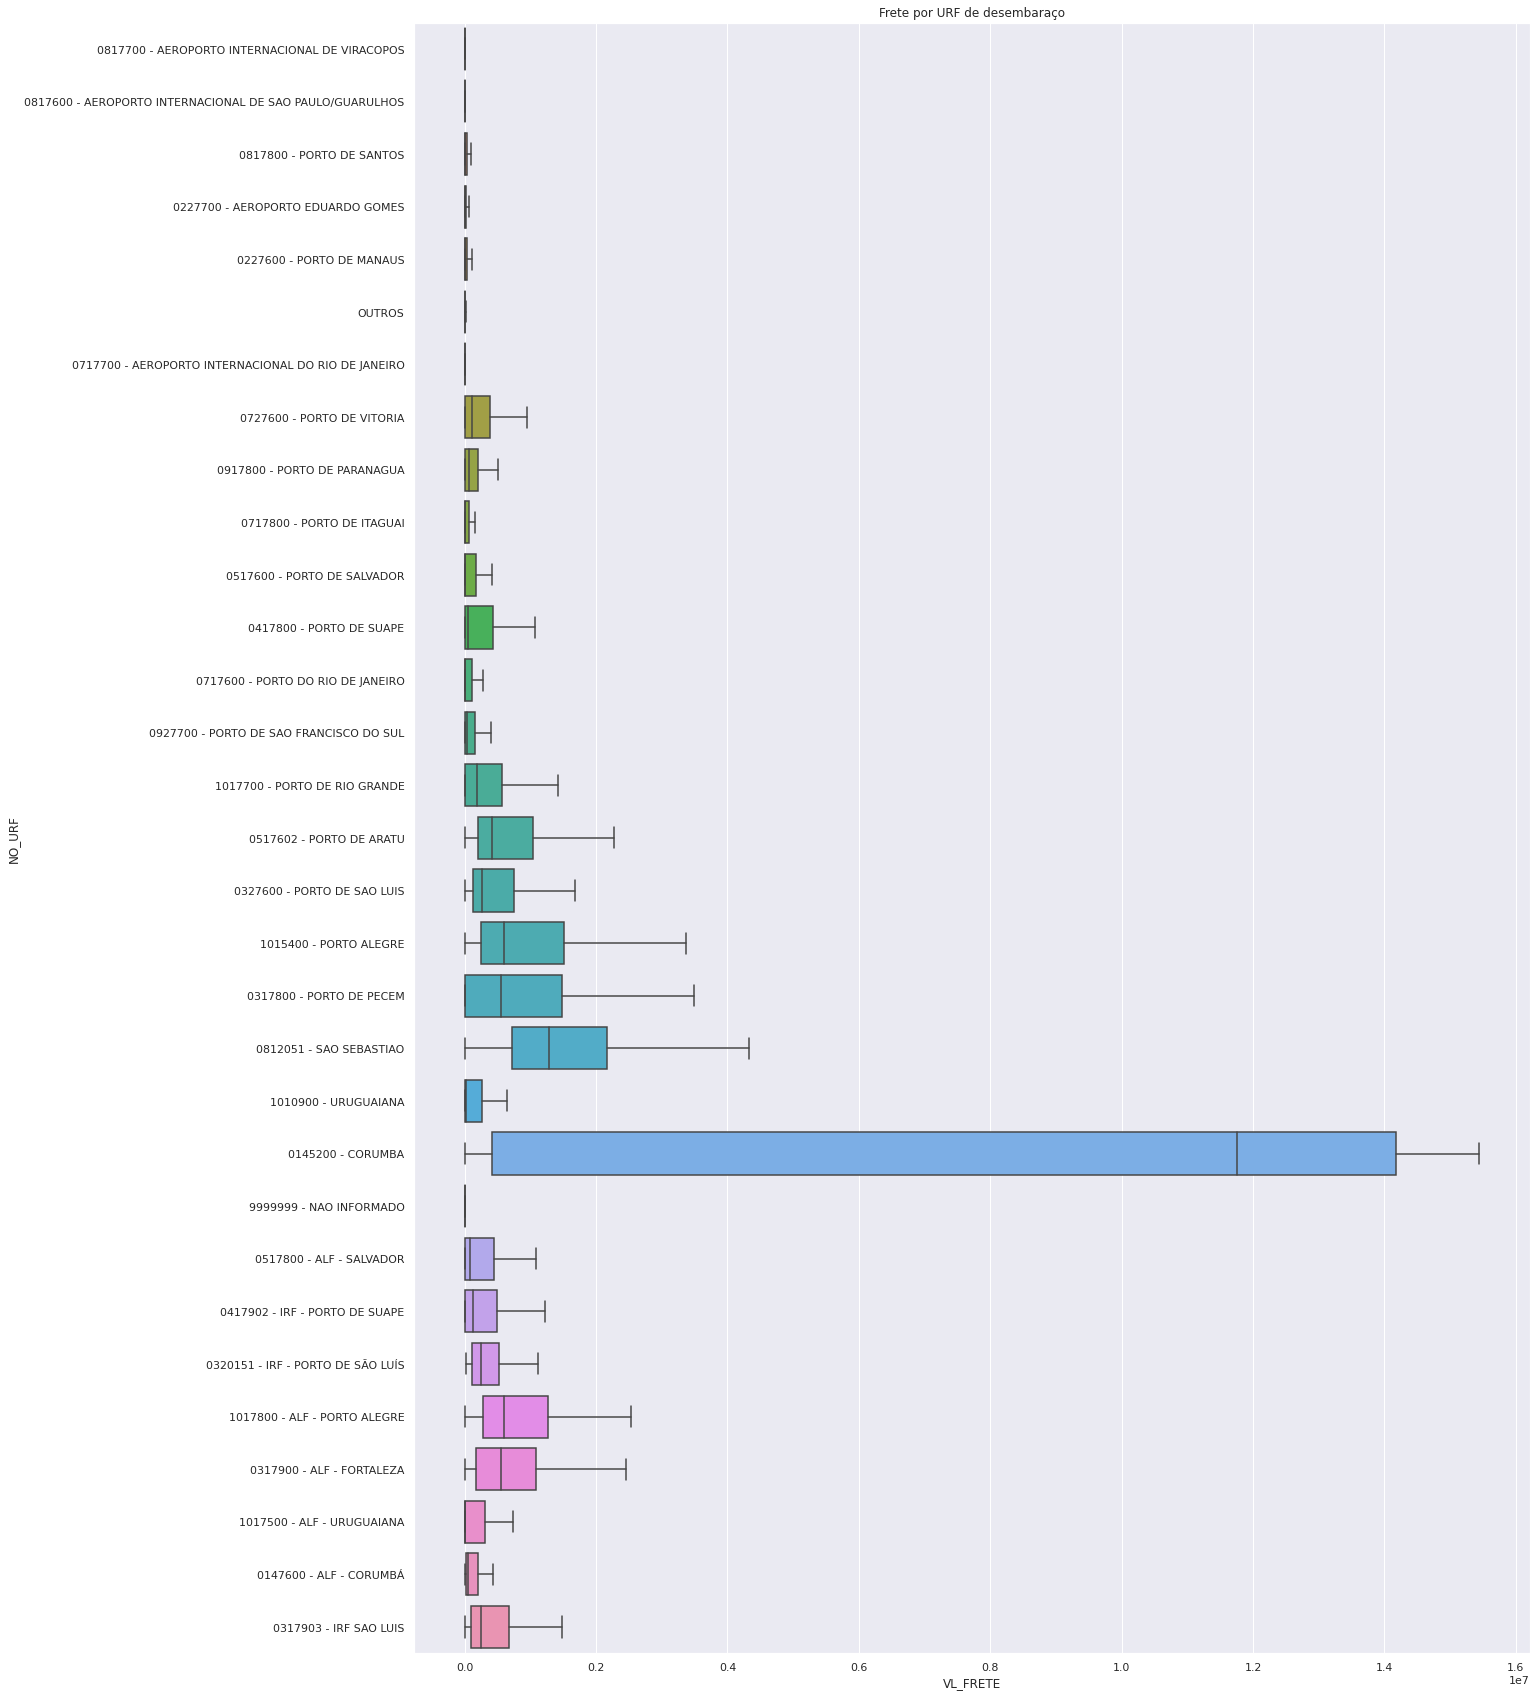

In [57]:
fig, ax2 = plt.subplots(sharey=False, figsize=(20,30))
plt.title("Frete por URF de desembaraço")
sns.boxplot(y='NO_URF', x='VL_FRETE', data=df_total, showfliers = False, ax=ax2)
#plt.xticks(rotation=70)
plt.show()
#plt.savefig('imagens/tipoCE2.png',bbox_inches='tight')

### Análise Variáveis quantitativas


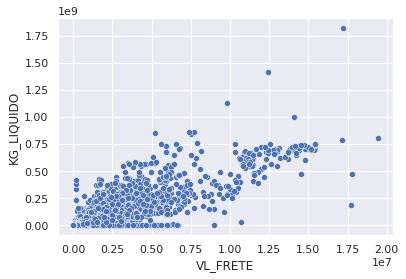

In [58]:
sns.scatterplot(x='VL_FRETE', y='KG_LIQUIDO', data=df_total)

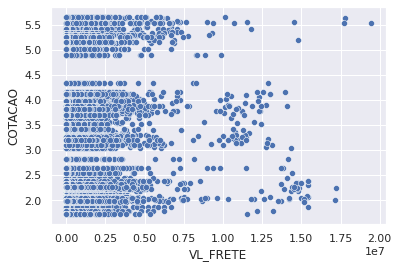

In [59]:
sns.scatterplot(x='VL_FRETE', y='COTACAO', data=df_total)

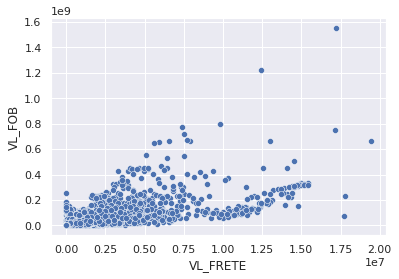

In [60]:
sns.scatterplot(x='VL_FRETE', y='VL_FOB', data=df_total)

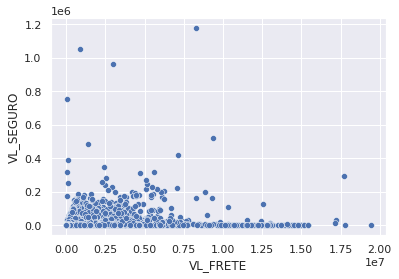

In [61]:
sns.scatterplot(x='VL_FRETE', y='VL_SEGURO', data=df_total)

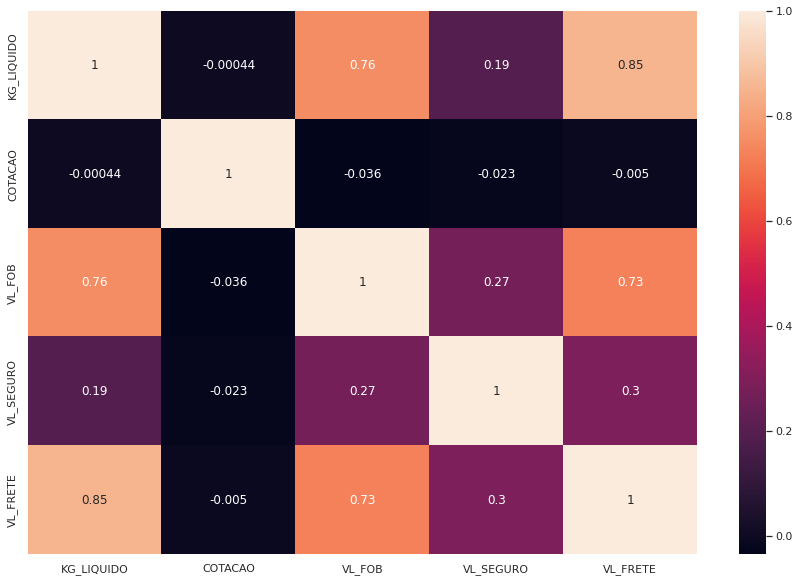

In [62]:
df_quantitativas = df_total[['KG_LIQUIDO','COTACAO','VL_FOB','VL_SEGURO','VL_FRETE']]

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(15, 10))

    ax = sns.heatmap(df_quantitativas.corr(),annot=True)

In [63]:
df_quantmensal = df_total[['CO_ANO','KG_LIQUIDO','VL_FOB','VL_SEGURO','VL_FRETE']]
df_quantmensal = df_quantmensal.groupby(['CO_ANO']).sum()
df_quantmensal.reset_index(inplace=True)
df_quantmensal = df_quantmensal[df_quantmensal.CO_ANO < 2022]
df_quantmensal.head()

,CO_ANO,KG_LIQUIDO,VL_FOB,VL_SEGURO,VL_FRETE
0,2012,71305458692,61269207270,26022510,1986105684
1,2013,84920231954,69513369370,25973221,2231812772
2,2014,89559336743,66615126051,22960268,2212004565
3,2015,82417720671,42586161662,18711802,1829456672
4,2016,75402445312,30501715347,14915050,1365429633


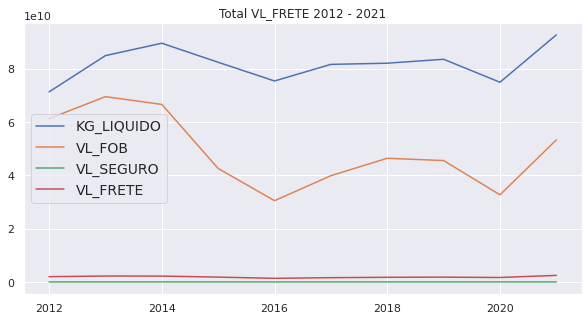

In [64]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Total VL_FRETE 2012 - 2021")
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.KG_LIQUIDO)
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FOB)
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_SEGURO)
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FRETE)
plt.legend(['KG_LIQUIDO','VL_FOB','VL_SEGURO','VL_FRETE'], fontsize=14)
plt.show()

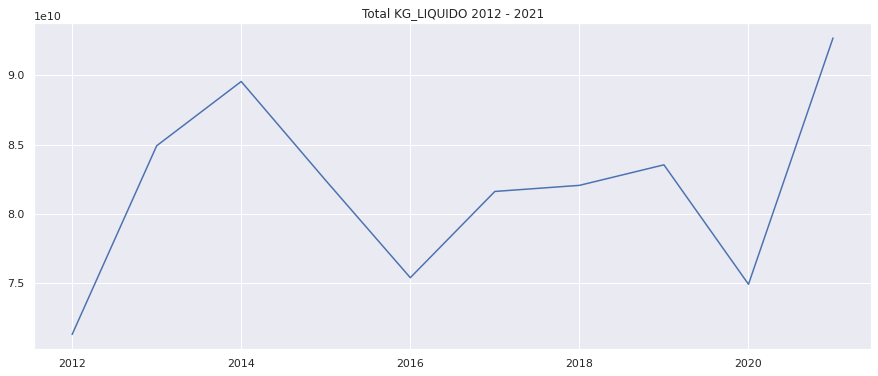

In [65]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Total KG_LIQUIDO 2012 - 2021")
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.KG_LIQUIDO)
plt.show()

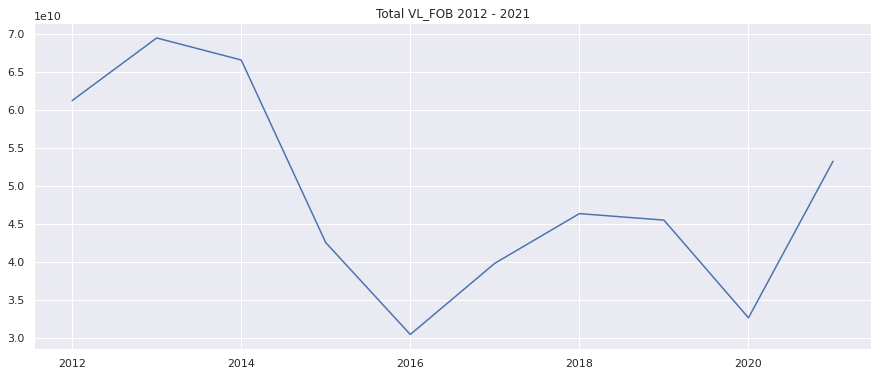

In [66]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Total VL_FOB 2012 - 2021")
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FOB)
plt.show()

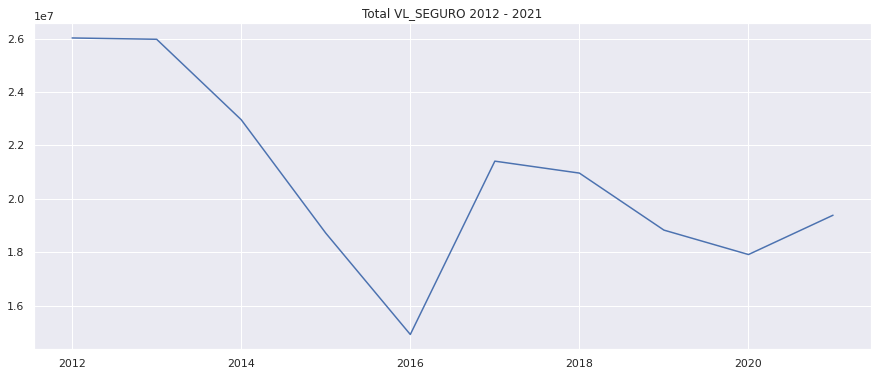

In [67]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Total VL_SEGURO 2012 - 2021")
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_SEGURO)
plt.show()

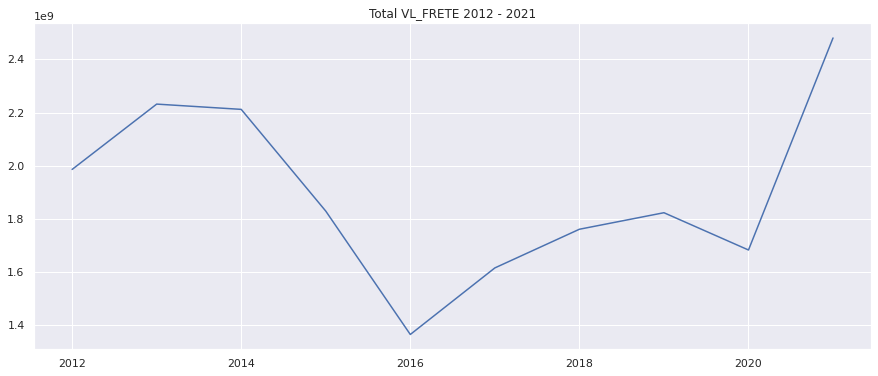

In [68]:
sns.set_theme(style="darkgrid")

f, ax = plt.subplots(figsize=(15, 6))
ax.set_title("Total VL_FRETE 2012 - 2021")
plt.plot(df_quantmensal.CO_ANO,df_quantmensal.VL_FRETE)
plt.show()

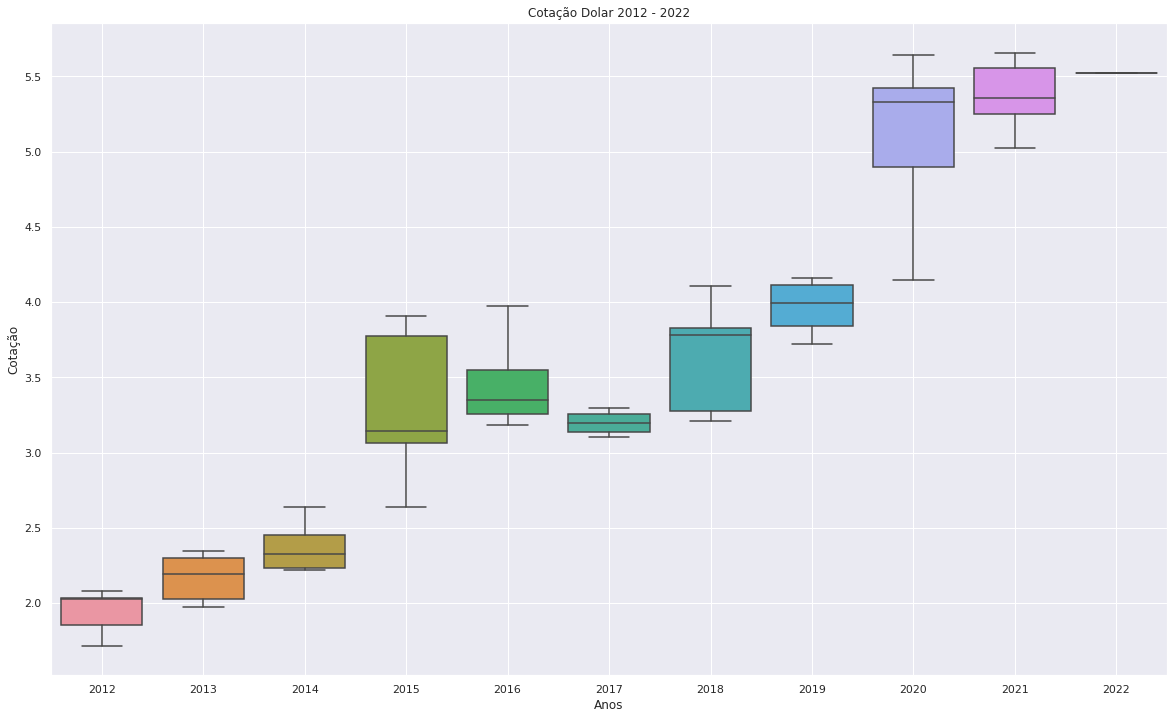

In [69]:
# Configurando tema
sns.set_theme(style="darkgrid")


# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title("Cotação Dolar 2012 - 2022")
sns.boxplot(x='CO_ANO', y='COTACAO', data=df_total, showfliers = False)
ax.set_ylabel("Cotação")
ax.set_xlabel("Anos")
plt.grid(True)
plt.show()

## Modelos de Machine Learning
-----


### Preparando o dataset df_final

In [78]:
df_final = df_total.copy()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117814 entries, 0 to 117813
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CO_ANO      117814 non-null  int64  
 1   CO_MES      117814 non-null  int64  
 2   NCM         117814 non-null  object 
 3   NO_PAIS     117814 non-null  object 
 4   SG_UF_NCM   117814 non-null  object 
 5   NO_VIA      117814 non-null  object 
 6   NO_URF      117814 non-null  object 
 7   KG_LIQUIDO  117814 non-null  int64  
 8   COTACAO     117814 non-null  float64
 9   VL_FOB      117814 non-null  int64  
 10  VL_SEGURO   117814 non-null  int64  
 11  VL_FRETE    117814 non-null  int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 15.7+ MB


In [79]:
df_final["NCM"] = df_final["NCM"].apply(lambda x: str(x)[:8])
df_final["NO_URF"] = df_final["NO_URF"].apply(lambda x: str(x)[:7])
df_final["NO_URF"] = df_final["NO_URF"].replace('OUTROS',0)

In [81]:
df_sigla = df_final[['SG_UF_NCM']]
df_sigla = df_sigla.drop_duplicates()
df_sigla.reset_index(inplace=True)
df_sigla.drop(['index'],axis=1,inplace=True)
df_sigla.reset_index(inplace=True)
df_sigla.at[8,'index']=0
df_sigla.at[0,'index']=8
df_sigla = df_sigla.sort_values(by='index')
df_sigla = df_sigla.rename(columns={"index":"CO_UF_NCM"})

In [82]:
df_final = df_final.merge(df_pais[['NO_PAIS','CO_PAIS']],on='NO_PAIS', how = 'left')
df_final = df_final.merge(df_sigla[['SG_UF_NCM','CO_UF_NCM']],on='SG_UF_NCM',how = 'left')
df_final = df_final.merge(df_via[['NO_VIA','CO_VIA']],on='NO_VIA',how = 'left')
df_final.fillna(value = 0,  
          inplace = True)
df_final = df_final[['CO_ANO','CO_MES','NCM','CO_PAIS','CO_UF_NCM','CO_VIA','NO_URF','KG_LIQUIDO','VL_FOB','COTACAO','VL_SEGURO','VL_FRETE']]
df_final

,CO_ANO,CO_MES,NCM,CO_PAIS,CO_UF_NCM,CO_VIA,NO_URF,KG_LIQUIDO,VL_FOB,COTACAO,VL_SEGURO,VL_FRETE
0,2012,6,85299020,0.0,8,4.0,0817700,35,3252,2.050600,3,538
1,2012,6,85177099,0.0,8,4.0,0817700,356,44496,2.050600,40,6150
2,2012,6,85177099,0.0,1,4.0,0817700,82,116919,2.050600,82,1334
3,2012,6,85423120,0.0,2,4.0,0817700,120,22194,2.050600,46,1861
4,2012,6,85423120,0.0,8,4.0,0817700,96,72146,2.050600,8,1328
...,...,...,...,...,...,...,...,...,...,...,...,...
117809,2012,2,10019900,586.0,7,0.0,0,156000,31668,1.717316,0,312
117810,2012,2,10019900,586.0,7,0.0,0,1500000,270000,1.717316,0,7500
117811,2012,2,10019900,586.0,13,0.0,0,320340,69834,1.717316,0,3844
117812,2012,2,27112100,97.0,13,8.0,0145200,468795053,204558151,1.717316,0,11544398


### Separando dados para treino e teste

In [84]:
from sklearn.model_selection import train_test_split

X, y = df_final.drop(['VL_FRETE'],axis=1), df_final.VL_FRETE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

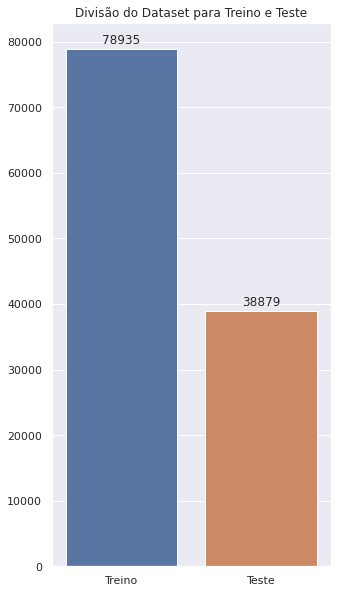

In [87]:
# Configurando Tema
sns.set_theme(style="darkgrid")

# Configurando tamanho da figura
fig, ax = plt.subplots(figsize=(5,10))
bar = sns.barplot(y=[X_train.shape[0],X_test.shape[0]],x=['Treino','Teste'])

for p in bar.patches:
    bar.annotate(int(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
ax.set_title("Divisão do Dataset para Treino e Teste")
plt.show()

## Treinamento

In [106]:
from sklearn.metrics import mean_squared_error, median_absolute_error,r2_score

In [155]:
def treinamento_metricas(clf,X_train, X_test, y_train, y_test):
    clf.fit(X_train,y_train)
    predict = clf.predict(X_test)
    r2 = r2_score(y_test, predict)
    mae = median_absolute_error(y_test, predict)

    soma = 0
    regr_y_test = []
    for val in y_test:
        soma += val
        regr_y_test.append(soma)

    soma = 0
    regr_y_predict = []
    for val in clf.predict(X_test):
        soma += val
        regr_y_predict.append(soma)

    # Configurando Tema
    sns.set_theme(style="darkgrid")

    # Configurando grafico
    fig, ax = plt.subplots(figsize=(15,15))

    plt.plot(range(len(regr_y_test)),regr_y_test,label='Gabarito')

    plt.plot(range(len(regr_y_predict)),regr_y_predict,label='Predição')

    ax.set_title('Progressão Aritmética Predição e Gabarito')

    plt.legend()
    plt.show()
    
    return r2,mae

## Decision Tree

In [137]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [138]:
tree = DecisionTreeRegressor(random_state=42)

In [139]:
tree.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [140]:
predict = tree.predict(X_test)
r2 = r2_score(y_test, predict)
mae = median_absolute_error(y_test, predict)
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8627742358836337
MAE: 672.0



In [141]:
tree2 = DecisionTreeRegressor(random_state=42)

In [144]:
parametros_tree2 = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                   'min_samples_split':[2,3,4,5,6,7,8,9,10],}

In [145]:
grid_tree2 = GridSearchCV(estimator=tree2, param_grid=parametros_tree2,cv=10,n_jobs=-1)

In [146]:
grid_tree2.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [147]:
grid_tree2.best_params_

{'max_depth': 15, 'min_samples_split': 10}

In [148]:
tree_final = DecisionTreeRegressor(random_state=42,max_depth=15,min_samples_split=10)
tree_final.fit(X_train,y_train)

predict = tree_final.predict(X_test)
r2 = r2_score(y_test, predict)
mae = median_absolute_error(y_test, predict)
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8811756408942293
MAE: 697.05078125



In [95]:
from sklearn.tree import DecisionTreeRegressor

In [96]:
tree = DecisionTreeRegressor()

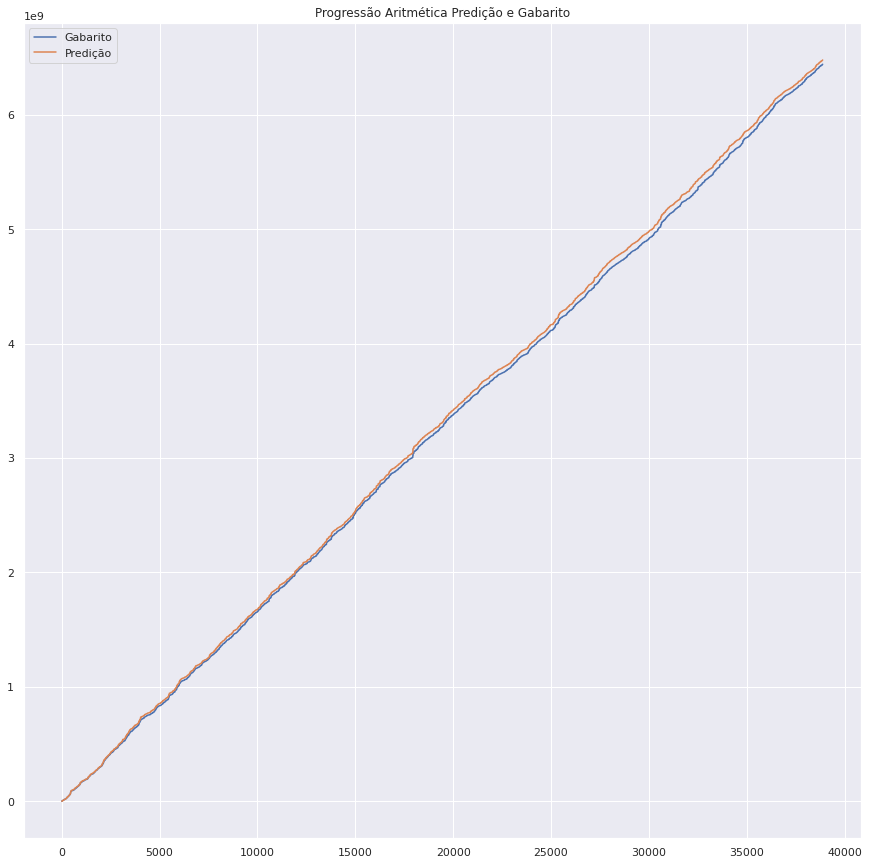

In [156]:
r2, mae = treinamento_metricas(tree,X_train, X_test, y_train, y_test)

In [98]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8751357971630749
MAE: 660.0



## K-Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
knn = KNeighborsRegressor()

In [157]:
knn.fit(X_train,y_train)

KNeighborsRegressor()

In [158]:
predict = knn.predict(X_test)
r2 = r2_score(y_test, predict)
mae = median_absolute_error(y_test, predict)
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8225828211285713
MAE: 1296.6



In [160]:
knn2 = KNeighborsRegressor()

In [165]:
parametros_knn2 = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                   'weights':['uniform','distance'],
                   'metric':['euclidean','manhattan']}

In [167]:
grid_knn2 = GridSearchCV(knn2, parametros_knn2,verbose=1,cv=3,n_jobs=-1)

In [168]:
grid_knn2.fit(X_train,y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [169]:
grid_knn2.best_params_

{'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}

In [173]:
knn_final = KNeighborsRegressor(metric='manhattan',n_neighbors=12, weights='distance')
knn_final.fit(X_train,y_train)

predict = knn_final.predict(X_test)
r2 = r2_score(y_test, predict)
mae = median_absolute_error(y_test, predict)
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8488616060351173
MAE: 1173.933052159832



In [99]:
from sklearn.neighbors import KNeighborsRegressor

In [100]:
knn = KNeighborsRegressor()

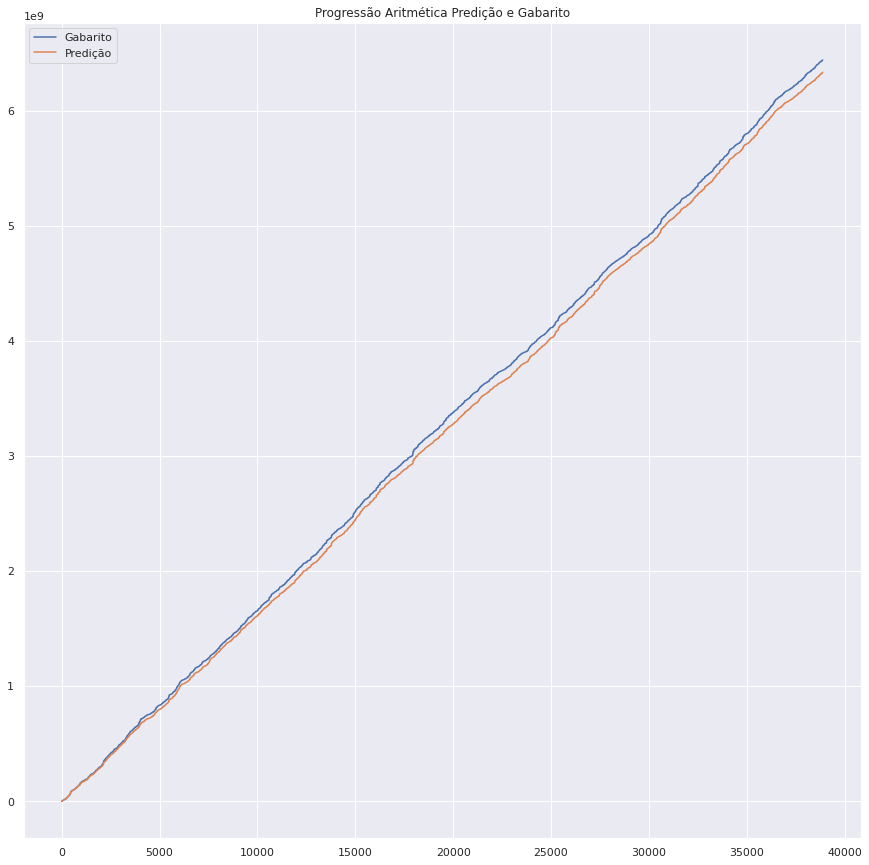

In [175]:
r2, mae = treinamento_metricas(knn,X_train, X_test, y_train, y_test)

In [102]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.8225828211285713
MAE: 1296.6



## Random Forest

In [103]:
from sklearn.ensemble import RandomForestRegressor

In [104]:
rfr = RandomForestRegressor(random_state=42)

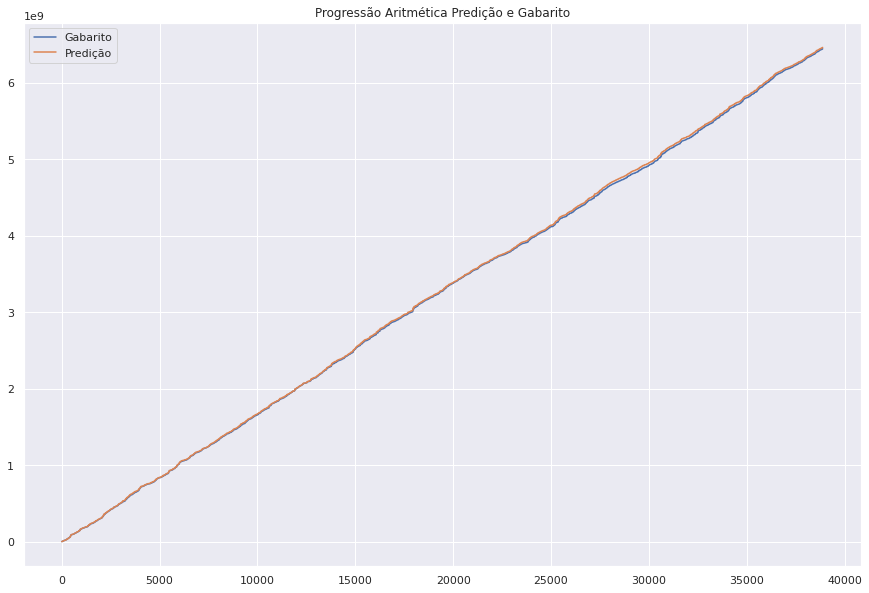

In [105]:
r2, mae = treinamento_metricas(rfr,X_train, X_test, y_train, y_test)

In [ ]:
print(f'\nR2: {r2}\nMAE: {mae}\n')


R2: 0.949648079647211
MAE: 578.7



### Exportando modelo
-----


In [ ]:
import pickle
with open("model.mod","wb") as outfile:
    pickle.dump(rfr,outfile)

## Importando melhor modelo
-----


In [ ]:
rfr = pickle.load(open("model.mod","rb"))

In [ ]:
print(f"Predicao do modelo: {rfr.predict(X_test)[0]}")
print(f"Valor real: {y_test[0]}")

Predicao do modelo: 218.93


KeyError: ignored

### Restante
-----


In [ ]:
df_importacao = df_importacao[df_importacao.VL_FOB > 0]
df_importacao.info()
df_importacao.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268821 entries, 17700329 to 36389684
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   CO_ANO      268821 non-null  int64 
 1   CO_MES      268821 non-null  int64 
 2   CO_NCM      268821 non-null  int64 
 3   CO_UNID     268821 non-null  int64 
 4   CO_PAIS     268821 non-null  int64 
 5   SG_UF_NCM   268821 non-null  object
 6   CO_VIA      268821 non-null  int64 
 7   CO_URF      268821 non-null  int64 
 8   QT_ESTAT    268821 non-null  int64 
 9   KG_LIQUIDO  268821 non-null  int64 
 10  VL_FOB      268821 non-null  int64 
 11  VL_FRETE    268821 non-null  int64 
 12  VL_SEGURO   268821 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 28.7+ MB


,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
17700329,2012,12,85369090,11,249,MG,1,817800,4727460,3036,152808,4743,78
17700358,2012,3,85045000,11,160,AM,1,227600,23941008,25934,973057,20817,1280
17700372,2012,2,31042090,10,149,GO,1,817800,6900000,6900000,3656925,207000,6769
17700456,2012,5,85332120,11,383,SP,4,817700,2336047,86,27603,1143,24
17700526,2012,3,85369040,11,399,RS,4,1017600,97819,163,21980,2450,35


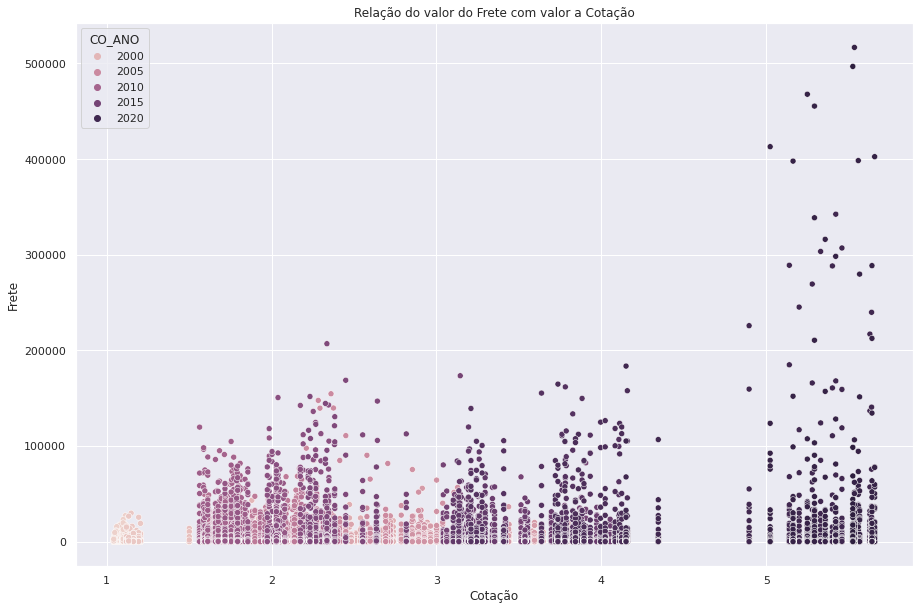

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='COTACAO',y='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Cotação')
ax.set_ylabel('Frete')

ax.set_title('Relação do valor do Frete com valor a Cotação')

plt.show()

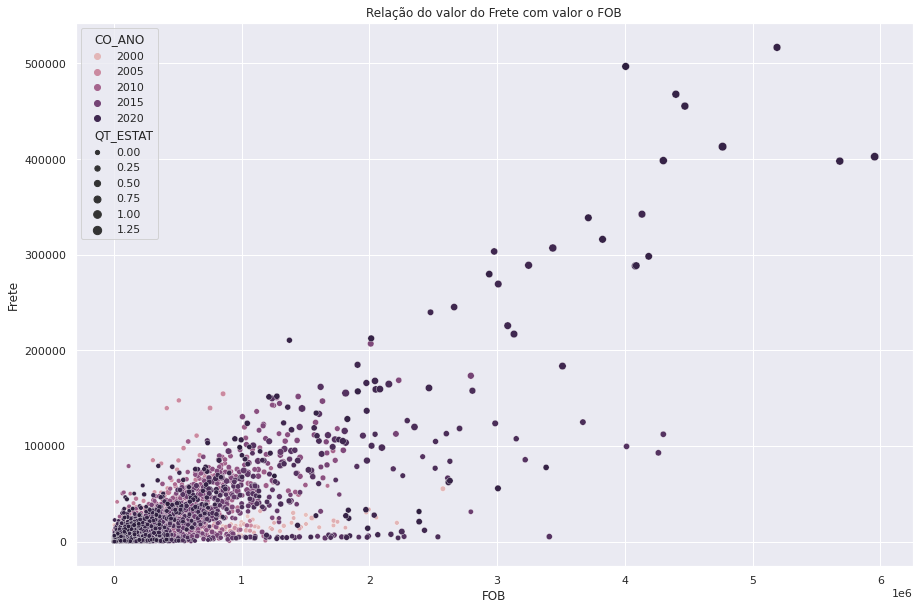

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(data=df_produto,x='VL_FOB',y='VL_FRETE',size='QT_ESTAT',hue='CO_ANO')
ax.set_ylabel('Frete')
ax.set_xlabel('FOB')

ax.set_title('Relação do valor do Frete com valor o FOB')

plt.show()

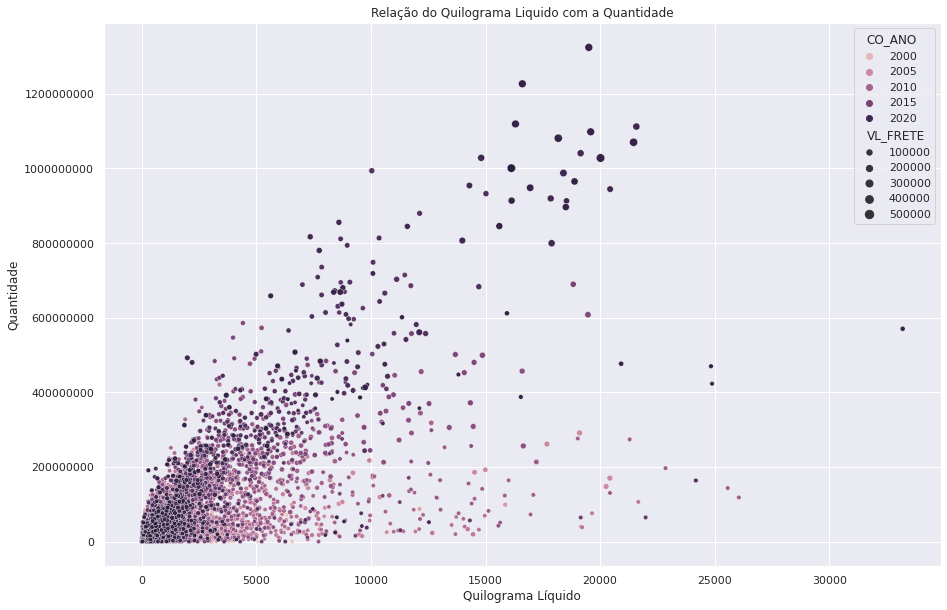

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
g = sns.scatterplot(data=df_produto,x='KG_LIQUIDO',y='QT_ESTAT',size='VL_FRETE',hue='CO_ANO')
ax.set_xlabel('Quilograma Líquido')
ax.set_ylabel('Quantidade')

ax.set_title('Relação do Quilograma Liquido com a Quantidade')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: int(y)))